<h1 align="center" style="color: #FF69B4;">Image Classification with SVM: Complete Analysis</h1>

<h2 align="center" style="color: #00BFFF;">Project Overview</h2>

 In this project, we will work with the well-known MNIST dataset, which has images of handwritten numbers. We will build and test different Support Vector Machine (SVM) models to see how they perform. This project has several interesting parts:

- **Explore and look at the dataset**
- **Train SVM models and compare them**
- **Analyze the performance with clear and beautiful graphs**
- **Understand which features are most important and how the decision boundaries work**

Let’s begin by getting our environment ready and loading the important libraries we need. This will help us get started!

---


In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import time
from matplotlib.gridspec import GridSpec
import warnings

warnings.filterwarnings('ignore')

# Configure matplotlib for high-quality plots
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# Load the digits dataset
print("Loading the digits dataset...")
digits = datasets.load_digits()

# Display basic dataset information
print("Dataset loaded successfully")
print(f"Dataset shape: {digits.data.shape}")
print(f"Number of classes: {len(np.unique(digits.target))}")
print(f"Image dimensions: {digits.images.shape[1:]} pixels")
print(f"Total samples: {len(digits.data)}")

# Prepare the data
X = digits.data
y = digits.target
n_samples, n_features = X.shape

print("Data preprocessing complete")
print(f"Features per sample: {n_features}")
print(f"Approximate samples per class: {n_samples // len(np.unique(y))}")

# Continue with model training and analysis...


Loading the digits dataset...
Dataset loaded successfully
Dataset shape: (1797, 64)
Number of classes: 10
Image dimensions: (8, 8) pixels
Total samples: 1797
Data preprocessing complete
Features per sample: 64
Approximate samples per class: 179


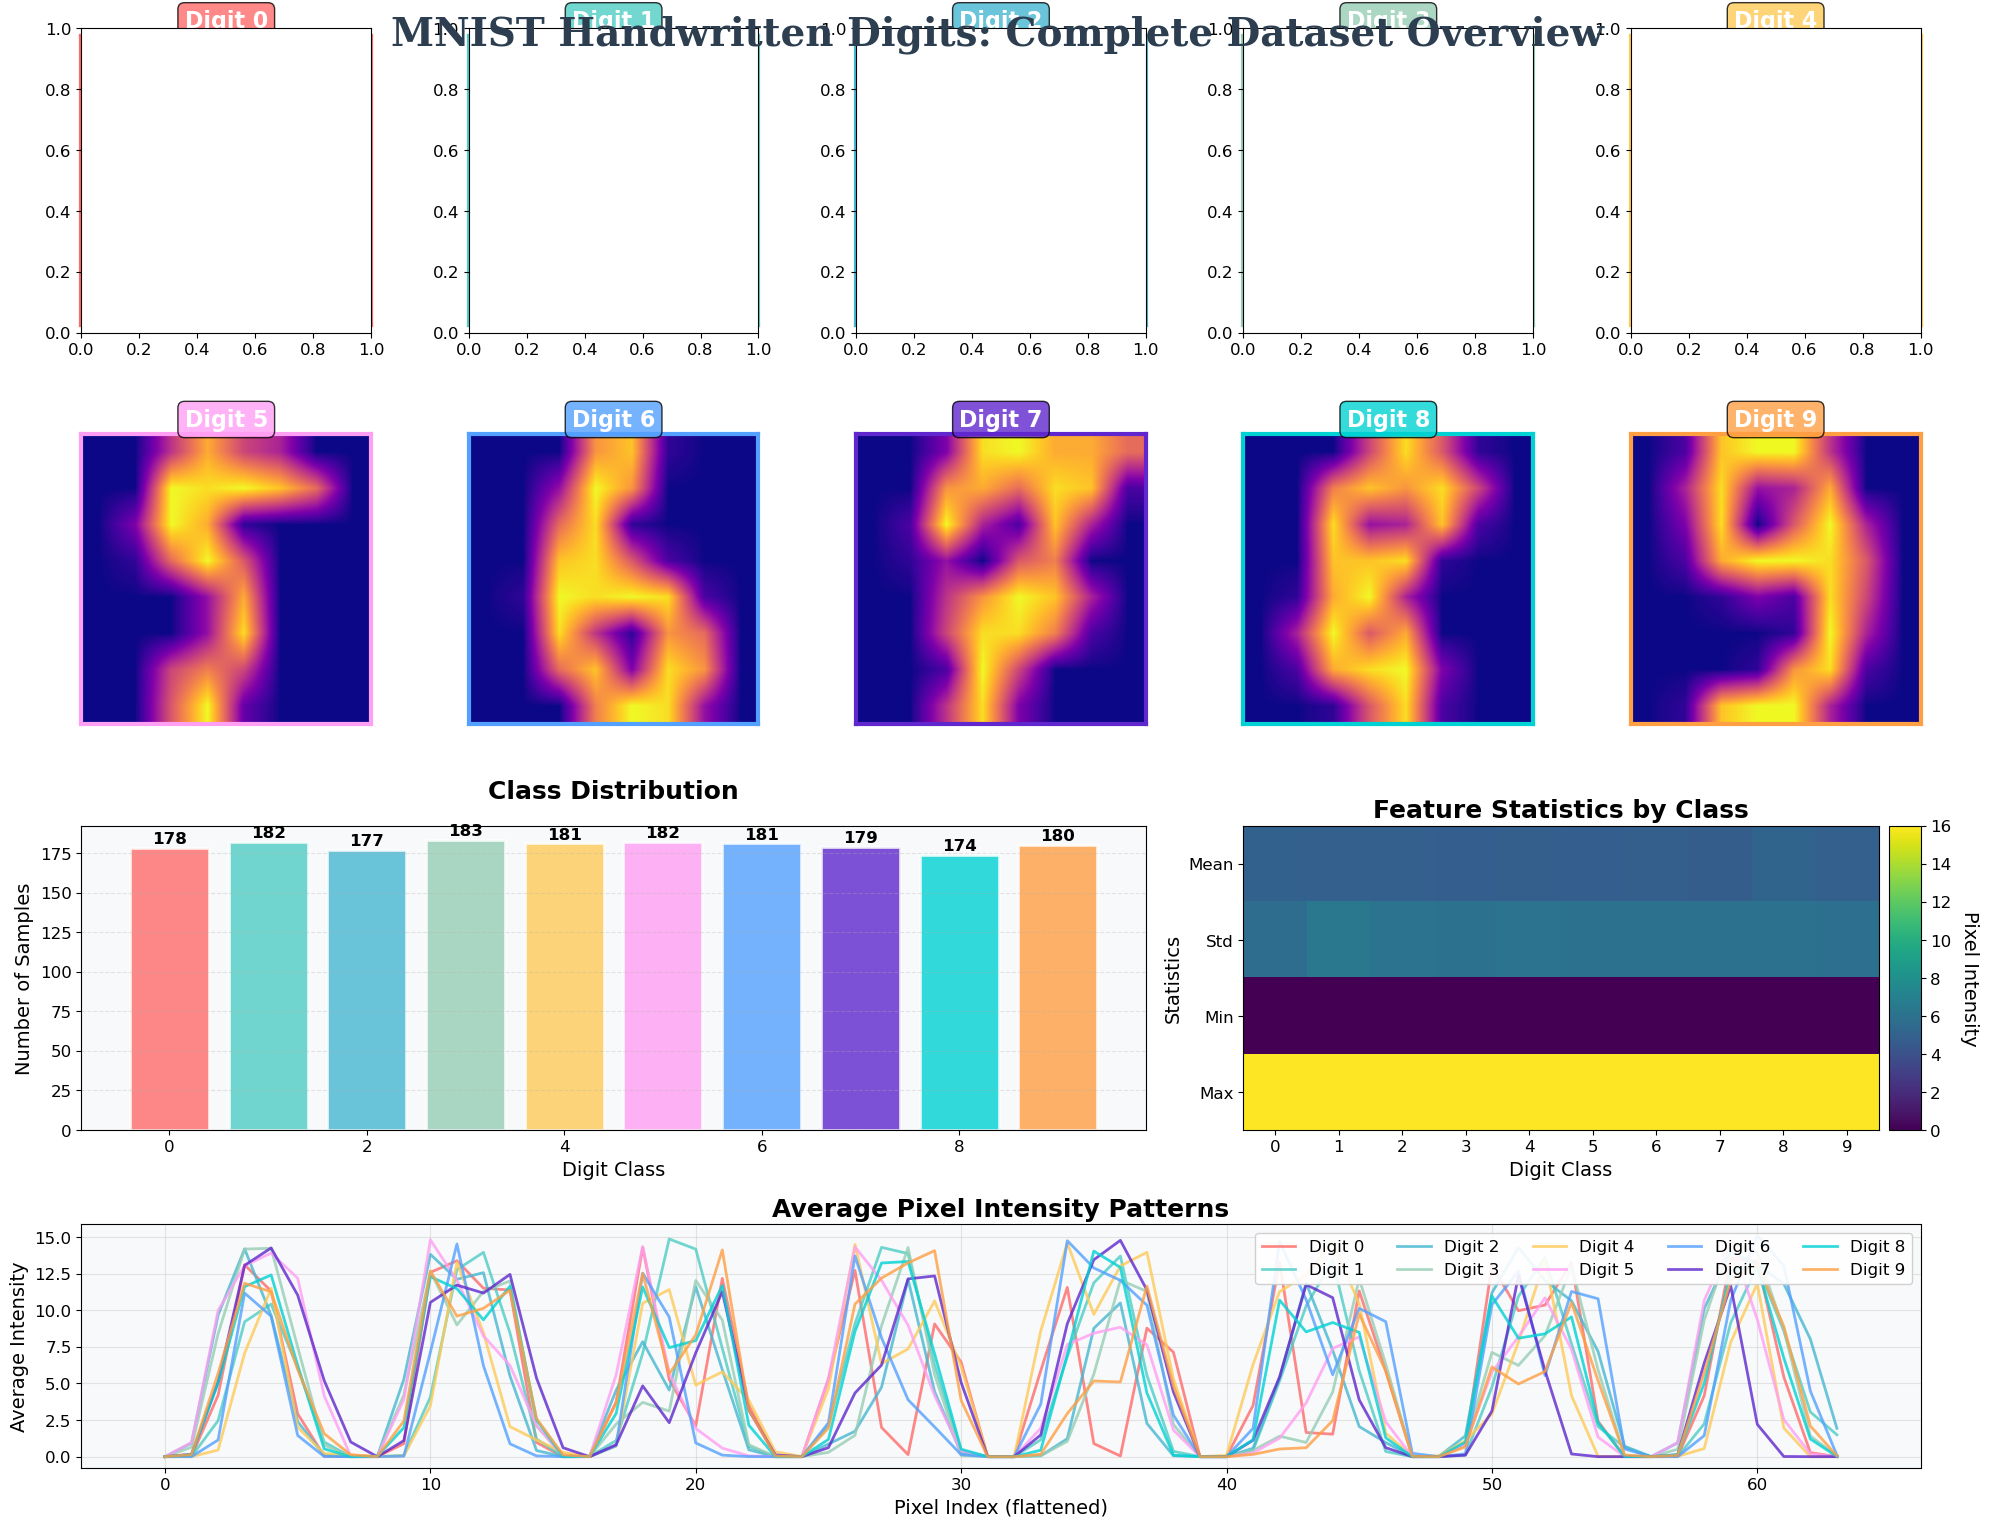

Most balanced digit: 3 (183 samples)
Least common digit: 8 (174 samples)
Average pixel intensity: 4.88
Dataset variance: 36.20


In [8]:
# Create custom color schemes for plots
def create_vibrant_colormap():
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57', 
              '#FF9FF3', '#54A0FF', '#5F27CD', '#00D2D3', '#FF9F43']
    from matplotlib.colors import ListedColormap
    return ListedColormap(colors)

def create_gradient_background(ax, color1='#667eea', color2='#764ba2'):
    gradient = np.linspace(0, 1, 256).reshape(256, -1)
    gradient = np.vstack((gradient, gradient))
    ax.imshow(gradient, extent=[ax.get_xlim()[0], ax.get_xlim()[1], 
                               ax.get_ylim()[0], ax.get_ylim()[1]], 
              aspect='auto', alpha=0.3)

# Dataset overview visualization
vibrant_cmap = create_vibrant_colormap()
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(4, 5, figure=fig, height_ratios=[1, 1, 1, 0.8])

fig.suptitle('MNIST Handwritten Digits: Complete Dataset Overview', 
             fontsize=28, fontweight='bold', y=0.95,
             color='#2C3E50', fontfamily='serif')

# Display sample digits for each class (0-9)
for digit in range(10):
    ax = fig.add_subplot(gs[0, digit % 5])
    if digit >= 5:
        ax = fig.add_subplot(gs[1, digit - 5])
    
    digit_indices = np.where(y == digit)[0]
    sample_idx = digit_indices[np.random.randint(0, len(digit_indices))]
    
    ax.imshow(digits.images[sample_idx], cmap='plasma', interpolation='bilinear')
    
    ax.set_title(f'Digit {digit}', fontsize=16, fontweight='bold', 
                color='white', bbox=dict(boxstyle="round,pad=0.3", 
                facecolor=vibrant_cmap.colors[digit], alpha=0.8))
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    for spine in ax.spines.values():
        spine.set_color(vibrant_cmap.colors[digit])
        spine.set_linewidth(3)

# Class distribution bar chart
ax_dist = fig.add_subplot(gs[2, :3])
class_counts = np.bincount(y)
bars = ax_dist.bar(range(10), class_counts, 
                   color=[vibrant_cmap.colors[i] for i in range(10)],
                   alpha=0.8, edgecolor='white', linewidth=2)

for bar, count in zip(bars, class_counts):
    height = bar.get_height()
    ax_dist.text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{count}', ha='center', va='bottom', 
                fontweight='bold', fontsize=12)

ax_dist.set_title('Class Distribution', fontsize=18, fontweight='bold', pad=20)
ax_dist.set_xlabel('Digit Class', fontsize=14)
ax_dist.set_ylabel('Number of Samples', fontsize=14)
ax_dist.grid(axis='y', alpha=0.3, linestyle='--')
ax_dist.set_facecolor('#F8F9FA')

# Feature statistics heatmap
ax_stats = fig.add_subplot(gs[2, 3:])
feature_stats = np.array([
    [np.mean(X[y == i]) for i in range(10)],
    [np.std(X[y == i]) for i in range(10)],
    [np.min(X[y == i]) for i in range(10)],
    [np.max(X[y == i]) for i in range(10)]
])

im = ax_stats.imshow(feature_stats, cmap='viridis', aspect='auto')
ax_stats.set_title('Feature Statistics by Class', fontsize=18, fontweight='bold')
ax_stats.set_xlabel('Digit Class')
ax_stats.set_ylabel('Statistics')
ax_stats.set_yticks(range(4))
ax_stats.set_yticklabels(['Mean', 'Std', 'Min', 'Max'])
ax_stats.set_xticks(range(10))

divider = make_axes_locatable(ax_stats)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Pixel Intensity', rotation=270, labelpad=20)

# Pixel intensity distribution
ax_intensity = fig.add_subplot(gs[3, :])
for digit in range(10):
    digit_data = X[y == digit]
    avg_intensity = np.mean(digit_data, axis=0)
    ax_intensity.plot(avg_intensity, label=f'Digit {digit}', 
                     color=vibrant_cmap.colors[digit], linewidth=2, alpha=0.8)

ax_intensity.set_title('Average Pixel Intensity Patterns', fontsize=18, fontweight='bold')
ax_intensity.set_xlabel('Pixel Index (flattened)')
ax_intensity.set_ylabel('Average Intensity')
ax_intensity.legend(ncol=5, loc='upper right', framealpha=0.9)
ax_intensity.grid(True, alpha=0.3)
ax_intensity.set_facecolor('#F8F9FA')

plt.tight_layout()
plt.show()

print(f"Most balanced digit: {np.argmax(class_counts)} ({max(class_counts)} samples)")
print(f"Least common digit: {np.argmin(class_counts)} ({min(class_counts)} samples)")
print(f"Average pixel intensity: {np.mean(X):.2f}")
print(f"Dataset variance: {np.var(X):.2f}")


<h1 align="center" style="color: #FF8C00;">Data Preprocessing & Train-Test Split</h1>

Data preprocessing is an essential part of building a good machine learning model. In this section, we will:

- Perform data normalization and scaling
- Create a strategic train-test split
- Ensure balanced class representation
- Conduct quality checks and validation

Proper preprocessing helps us achieve reliable results and build a strong foundation for the SVM algorithms.

---


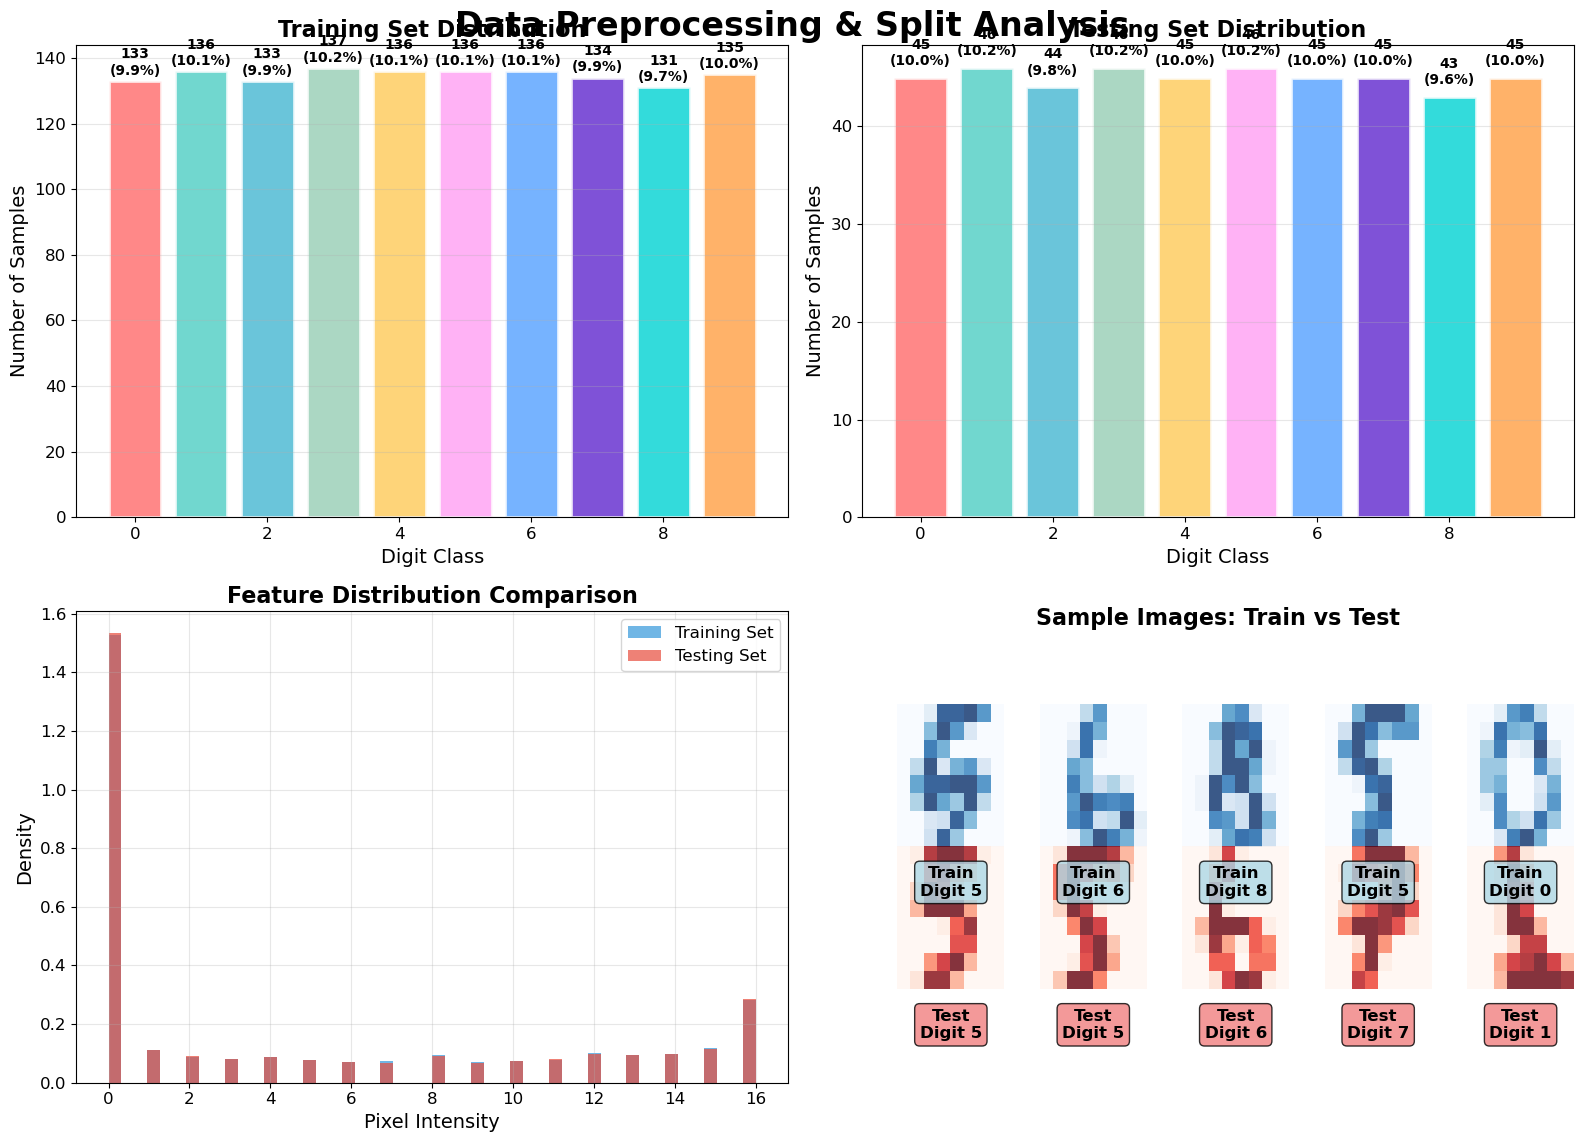


Preprocessing Statistics:
Training set balance check:
   Digit 0: Train 9.9% | Test 10.0% | Diff: 0.1%
   Digit 1: Train 10.1% | Test 10.2% | Diff: 0.1%
   Digit 2: Train 9.9% | Test 9.8% | Diff: 0.1%
   Digit 3: Train 10.2% | Test 10.2% | Diff: 0.1%
   Digit 4: Train 10.1% | Test 10.0% | Diff: 0.1%
   Digit 5: Train 10.1% | Test 10.2% | Diff: 0.1%
   Digit 6: Train 10.1% | Test 10.0% | Diff: 0.1%
   Digit 7: Train 9.9% | Test 10.0% | Diff: 0.1%
   Digit 8: Train 9.7% | Test 9.6% | Diff: 0.2%
   Digit 9: Train 10.0% | Test 10.0% | Diff: 0.0%

Feature statistics:
   Training set mean: 4.889 ± 6.015
   Testing set mean:  4.870 ± 6.021
   Feature range: [0.0, 16.0]


In [9]:
# Advanced data preprocessing with visualizations

# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Create visualization of the data split
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Data Preprocessing & Split Analysis', fontsize=24, fontweight='bold', y=0.95)

# Training set class distribution
train_counts = np.bincount(y_train)
bars1 = ax1.bar(range(10), train_counts, color=vibrant_cmap.colors, alpha=0.8,
                 edgecolor='white', linewidth=2)
ax1.set_title('Training Set Distribution', fontsize=16, fontweight='bold')
ax1.set_xlabel('Digit Class')
ax1.set_ylabel('Number of Samples')
ax1.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars1, train_counts)):
    percentage = count / len(y_train) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

# Testing set class distribution
test_counts = np.bincount(y_test)
bars2 = ax2.bar(range(10), test_counts, color=vibrant_cmap.colors, alpha=0.8,
                 edgecolor='white', linewidth=2)
ax2.set_title('Testing Set Distribution', fontsize=16, fontweight='bold')
ax2.set_xlabel('Digit Class')
ax2.set_ylabel('Number of Samples')
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (bar, count) in enumerate(zip(bars2, test_counts)):
    percentage = count / len(y_test) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom', 
             fontsize=10, fontweight='bold')

# Feature distribution comparison
ax3.hist(X_train.flatten(), bins=50, alpha=0.7, color='#3498db', 
          label='Training Set', density=True)
ax3.hist(X_test.flatten(), bins=50, alpha=0.7, color='#e74c3c', 
          label='Testing Set', density=True)
ax3.set_title('Feature Distribution Comparison', fontsize=16, fontweight='bold')
ax3.set_xlabel('Pixel Intensity')
ax3.set_ylabel('Density')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Sample images from train and test sets
sample_train_idx = np.random.choice(len(X_train), 5)
sample_test_idx = np.random.choice(len(X_test), 5)

# Create a subplot for sample comparisons
ax4.set_title('Sample Images: Train vs Test', fontsize=16, fontweight='bold')
ax4.axis('off')

# Display sample training images
for i, idx in enumerate(sample_train_idx):
    img = X_train[idx].reshape(8, 8)
    ax4.imshow(img, cmap='Blues', extent=[i*2, i*2+1.5, 2, 4], alpha=0.8)
    ax4.text(i*2+0.75, 1.5, f'Train\nDigit {y_train[idx]}', 
             ha='center', va='center', fontweight='bold', 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue', alpha=0.8))

# Display sample testing images
for i, idx in enumerate(sample_test_idx):
    img = X_test[idx].reshape(8, 8)
    ax4.imshow(img, cmap='Reds', extent=[i*2, i*2+1.5, 0, 2], alpha=0.8)
    ax4.text(i*2+0.75, -0.5, f'Test\nDigit {y_test[idx]}', 
             ha='center', va='center', fontweight='bold',
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightcoral', alpha=0.8))

ax4.set_xlim(-0.5, 9.5)
ax4.set_ylim(-1, 5)

plt.tight_layout()
plt.show()

# Detailed preprocessing statistics
print("\nPreprocessing Statistics:")
print("="*50)
print(f"Training set balance check:")
for i in range(10):
    train_pct = train_counts[i] / len(y_train) * 100
    test_pct = test_counts[i] / len(y_test) * 100
    print(f"   Digit {i}: Train {train_pct:.1f}% | Test {test_pct:.1f}% | Diff: {abs(train_pct-test_pct):.1f}%")

print(f"\nFeature statistics:")
print(f"   Training set mean: {np.mean(X_train):.3f} ± {np.std(X_train):.3f}")
print(f"   Testing set mean:  {np.mean(X_test):.3f} ± {np.std(X_test):.3f}")
print(f"   Feature range: [{np.min(X):.1f}, {np.max(X):.1f}]")


<h1 align="center" style="color: #228B22;">SVM Model Training & Kernel Comparison</h1>

This section focuses on training our SVM models and comparing different kernel functions:

- Linear SVM: fast and easy to interpret
- RBF (Radial Basis Function): can capture complex, non-linear patterns  
- Polynomial kernels: allow for different levels of complexity
- Performance benchmarking: understanding the trade-offs between speed and accuracy

Each kernel function has its advantages. We will determine which one performs best for recognizing handwritten digits.

---


Linear (C=1.0): Accuracy = 0.9756, Time = 0.042s
Linear (C=0.1): Accuracy = 0.9756, Time = 0.033s
RBF (C=1.0): Accuracy = 0.9911, Time = 0.058s
RBF (C=10.0): Accuracy = 0.9911, Time = 0.080s
Polynomial (degree=2): Accuracy = 0.9889, Time = 0.036s
Polynomial (degree=3): Accuracy = 0.9867, Time = 0.051s


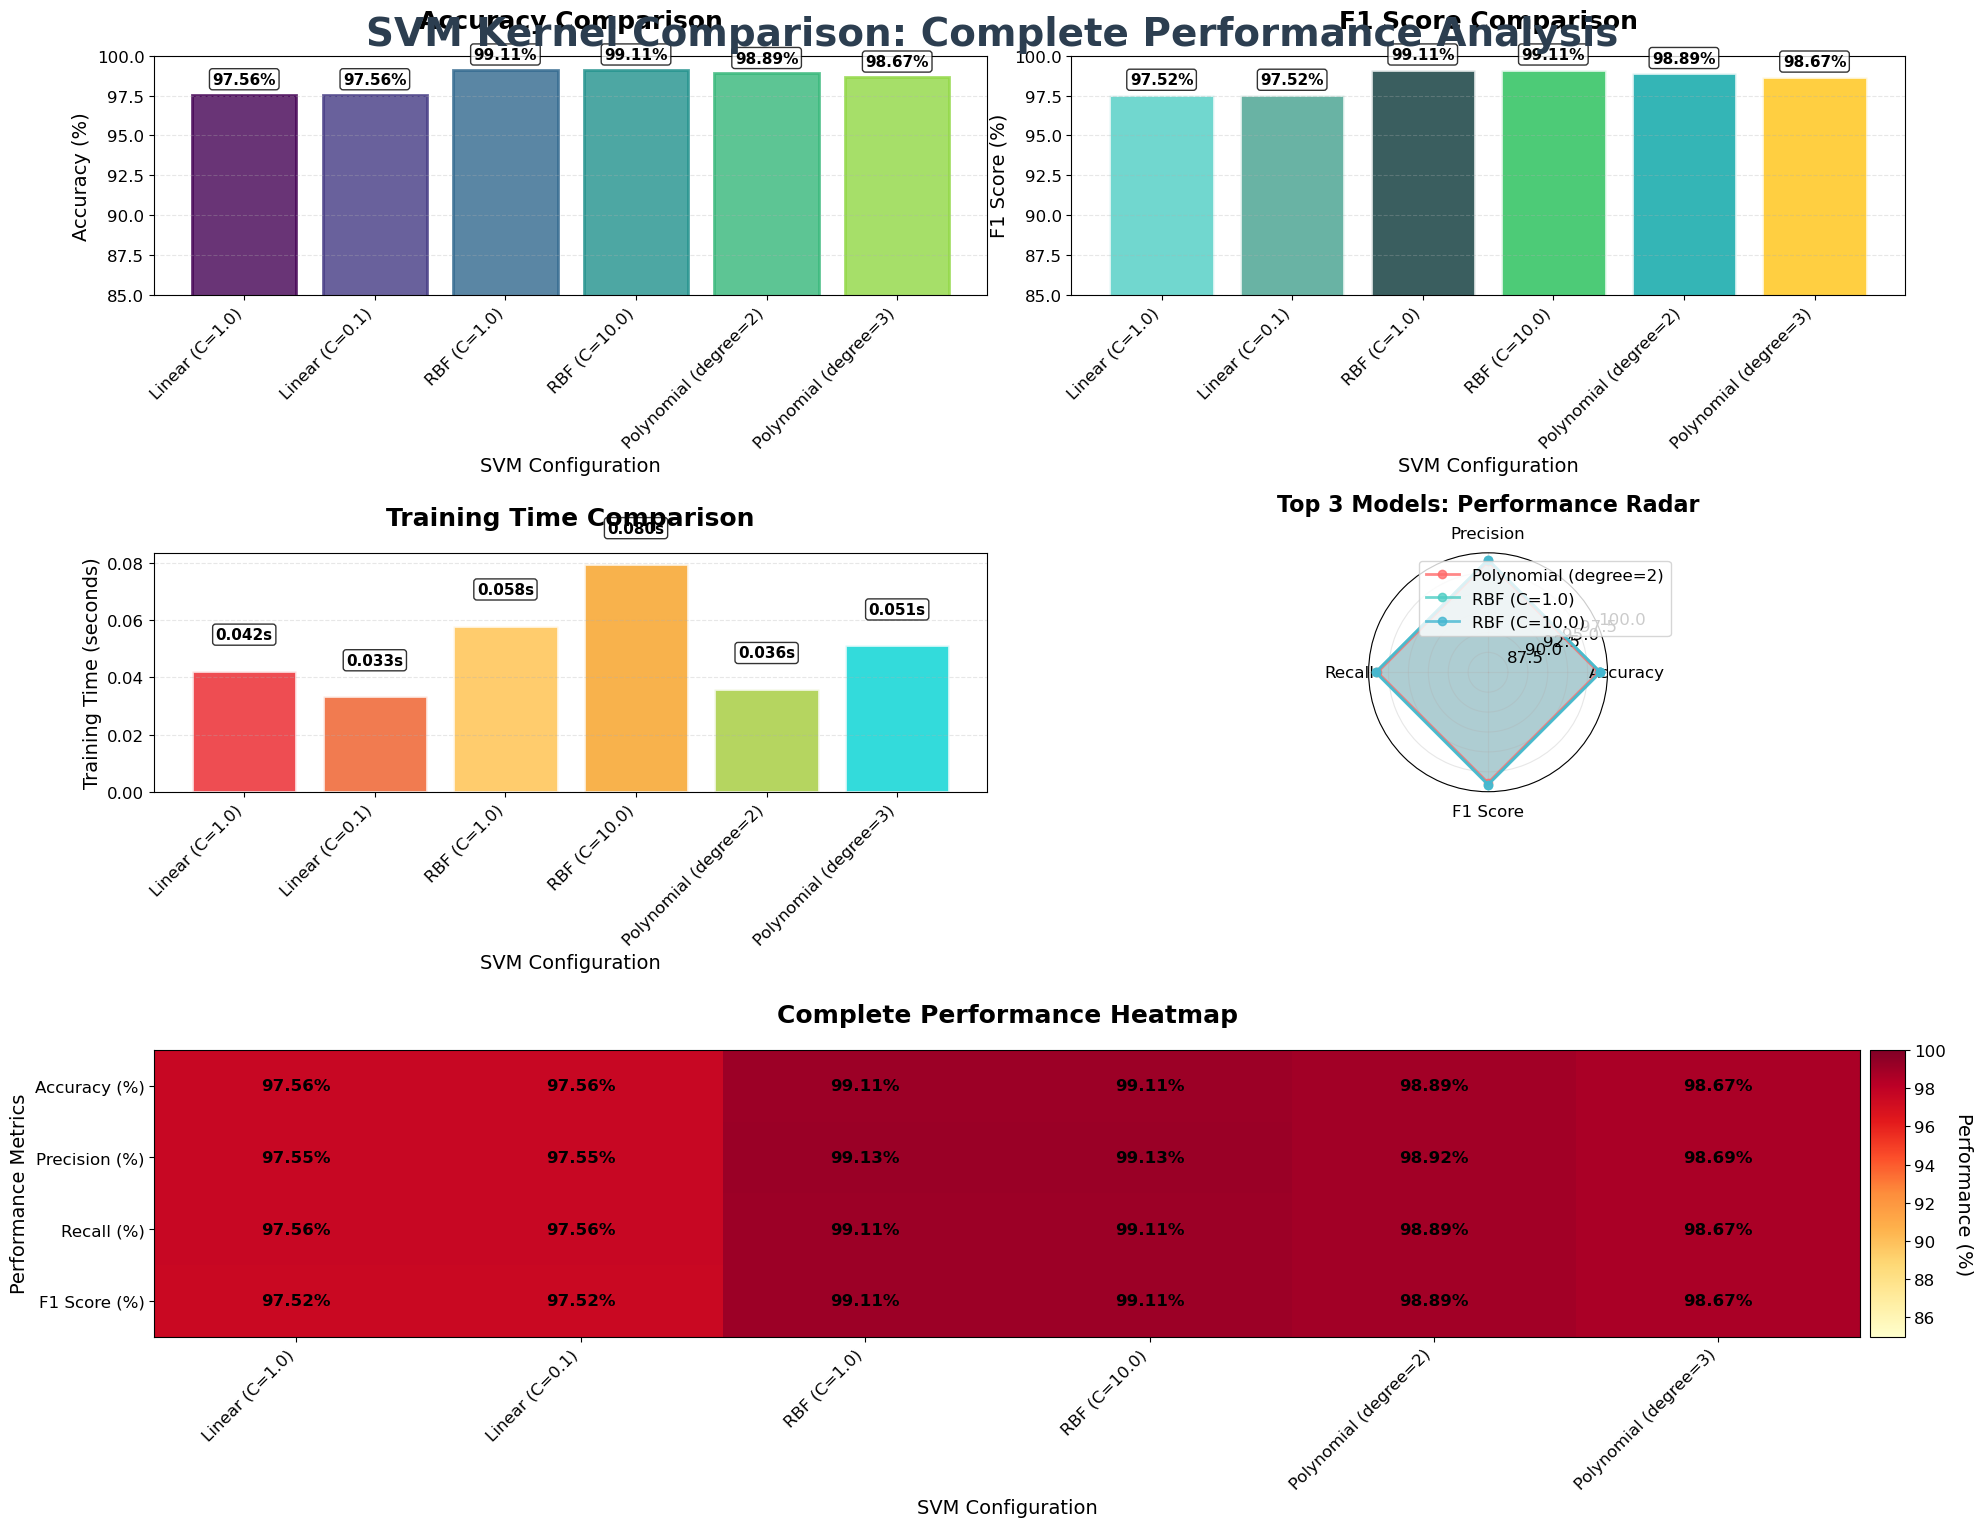


Best performing model: RBF (C=1.0)
   Accuracy: 0.9911
   F1 Score: 0.9911
   Training Time: 0.058s


In [10]:
# Comprehensive SVM model training and comparison

# Define different SVM configurations to test
svm_configs = [
    ('Linear (C=1.0)', svm.SVC(kernel='linear', C=1.0, random_state=42)),
    ('Linear (C=0.1)', svm.SVC(kernel='linear', C=0.1, random_state=42)),
    ('RBF (C=1.0)', svm.SVC(kernel='rbf', C=1.0, random_state=42)),
    ('RBF (C=10.0)', svm.SVC(kernel='rbf', C=10.0, random_state=42)),
    ('Polynomial (degree=2)', svm.SVC(kernel='poly', degree=2, C=1.0, random_state=42)),
    ('Polynomial (degree=3)', svm.SVC(kernel='poly', degree=3, C=1.0, random_state=42))
]

# Store results for comparison
results = {
    'names': [],
    'accuracies': [],
    'precisions': [],
    'recalls': [],
    'f1_scores': [],
    'training_times': [],
    'models': []
}

# Train each configuration
for name, model in svm_configs:
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results['names'].append(name)
    results['accuracies'].append(accuracy)
    results['precisions'].append(precision)
    results['recalls'].append(recall)
    results['f1_scores'].append(f1)
    results['training_times'].append(training_time)
    results['models'].append(model)
    
    print(f"{name}: Accuracy = {accuracy:.4f}, Time = {training_time:.3f}s")

# Visualization
fig = plt.figure(figsize=(20, 16))
gs = GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1.2])

fig.suptitle('SVM Kernel Comparison: Complete Performance Analysis', 
             fontsize=28, fontweight='bold', y=0.95, color='#2C3E50')

# Accuracy comparison
ax1 = fig.add_subplot(gs[0, 0])
bars = ax1.bar(range(len(results['names'])), 
               [acc * 100 for acc in results['accuracies']], 
               color=['#FF6B6B', '#FF8E53', '#FF6B9D', '#C44569', '#F8B500', '#786FA6'],
               alpha=0.8, edgecolor='white', linewidth=2)

for i, bar in enumerate(bars):
    bar.set_color(plt.cm.viridis(i / len(bars)))

ax1.set_title('Accuracy Comparison', fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('SVM Configuration', fontsize=14)
ax1.set_ylabel('Accuracy (%)', fontsize=14)
ax1.set_xticks(range(len(results['names'])))
ax1.set_xticklabels(results['names'], rotation=45, ha='right')
ax1.set_ylim(85, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for i, (bar, acc) in enumerate(zip(bars, results['accuracies'])):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc*100:.2f}%', ha='center', va='bottom', 
             fontweight='bold', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

# F1 Score comparison
ax2 = fig.add_subplot(gs[0, 1])
bars2 = ax2.bar(range(len(results['names'])), 
                [f1 * 100 for f1 in results['f1_scores']], 
                color=['#4ECDC4', '#44A08D', '#093637', '#20BF55', '#01A3A4', '#FFC312'],
                alpha=0.8, edgecolor='white', linewidth=2)

ax2.set_title('F1 Score Comparison', fontsize=18, fontweight='bold', pad=20)
ax2.set_xlabel('SVM Configuration', fontsize=14)
ax2.set_ylabel('F1 Score (%)', fontsize=14)
ax2.set_xticks(range(len(results['names'])))
ax2.set_xticklabels(results['names'], rotation=45, ha='right')
ax2.set_ylim(85, 100)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, f1 in zip(bars2, results['f1_scores']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{f1*100:.2f}%', ha='center', va='bottom', 
             fontweight='bold', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

# Training time comparison
ax3 = fig.add_subplot(gs[1, 0])
bars3 = ax3.bar(range(len(results['names'])), results['training_times'],
                color=['#EA2027', '#EE5A24', '#FFC048', '#F79F1F', '#A3CB38', '#00D2D3'],
                alpha=0.8, edgecolor='white', linewidth=2)

ax3.set_title('Training Time Comparison', fontsize=18, fontweight='bold', pad=20)
ax3.set_xlabel('SVM Configuration', fontsize=14)
ax3.set_ylabel('Training Time (seconds)', fontsize=14)
ax3.set_xticks(range(len(results['names'])))
ax3.set_xticklabels(results['names'], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

for bar, time_val in zip(bars3, results['training_times']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{time_val:.3f}s', ha='center', va='bottom', 
             fontweight='bold', fontsize=11,
             bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

# Comprehensive metrics radar chart
ax4 = fig.add_subplot(gs[1, 1], projection='polar')
angles = np.linspace(0, 2 * np.pi, 4, endpoint=False).tolist()
angles += angles[:1]

top_3_indices = np.argsort(results['accuracies'])[-3:]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for i, idx in enumerate(top_3_indices):
    values = [
        results['accuracies'][idx] * 100,
        results['precisions'][idx] * 100,
        results['recalls'][idx] * 100,
        results['f1_scores'][idx] * 100
    ]
    values += values[:1]
    
    ax4.plot(angles, values, 'o-', linewidth=2, label=results['names'][idx],
             color=colors[i], alpha=0.8)
    ax4.fill(angles, values, alpha=0.25, color=colors[i])

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1 Score'])
ax4.set_ylim(85, 100)
ax4.set_title('Top 3 Models: Performance Radar', fontsize=16, fontweight='bold', pad=30)
ax4.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax4.grid(True, alpha=0.3)

# Detailed performance heatmap
ax5 = fig.add_subplot(gs[2, :])
metrics_data = np.array([
    results['accuracies'],
    results['precisions'],
    results['recalls'],
    results['f1_scores']
]) * 100

im = ax5.imshow(metrics_data, cmap='YlOrRd', aspect='auto', vmin=85, vmax=100)
ax5.set_title('Complete Performance Heatmap', fontsize=18, fontweight='bold', pad=20)
ax5.set_xlabel('SVM Configuration', fontsize=14)
ax5.set_ylabel('Performance Metrics', fontsize=14)
ax5.set_xticks(range(len(results['names'])))
ax5.set_xticklabels(results['names'], rotation=45, ha='right')
ax5.set_yticks(range(4))
ax5.set_yticklabels(['Accuracy (%)', 'Precision (%)', 'Recall (%)', 'F1 Score (%)'])

for i in range(4):
    for j in range(len(results['names'])):
        ax5.text(j, i, f'{metrics_data[i, j]:.2f}%',
                  ha="center", va="center", color="black", fontweight='bold')

divider = make_axes_locatable(ax5)
cax = divider.append_axes("right", size="2%", pad=0.1)
cbar = plt.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Performance (%)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

# Select the best model for detailed analysis
best_model_idx = np.argmax(results['f1_scores'])
best_model = results['models'][best_model_idx]
best_model_name = results['names'][best_model_idx]

print(f"\nBest performing model: {best_model_name}")
print(f"   Accuracy: {results['accuracies'][best_model_idx]:.4f}")
print(f"   F1 Score: {results['f1_scores'][best_model_idx]:.4f}")
print(f"   Training Time: {results['training_times'][best_model_idx]:.3f}s")


<h1 align="center" style="color: #FF1493;">Model Predictions & Detailed Performance Analysis</h1>

In this section, we will evaluate our best model and understand its performance in detail:

- Make predictions on the test dataset
- Visualize the confusion matrix
- Analyze per-class performance metrics
- Conduct error analysis and identify patterns

This thorough analysis will help us see how well our SVM classifier works and where it might have difficulties with certain digit patterns.

---


Making predictions with the best model: RBF (C=1.0)
Overall Accuracy: 0.9911 (99.11%)
Weighted F1 Score: 0.9911 (99.11%)


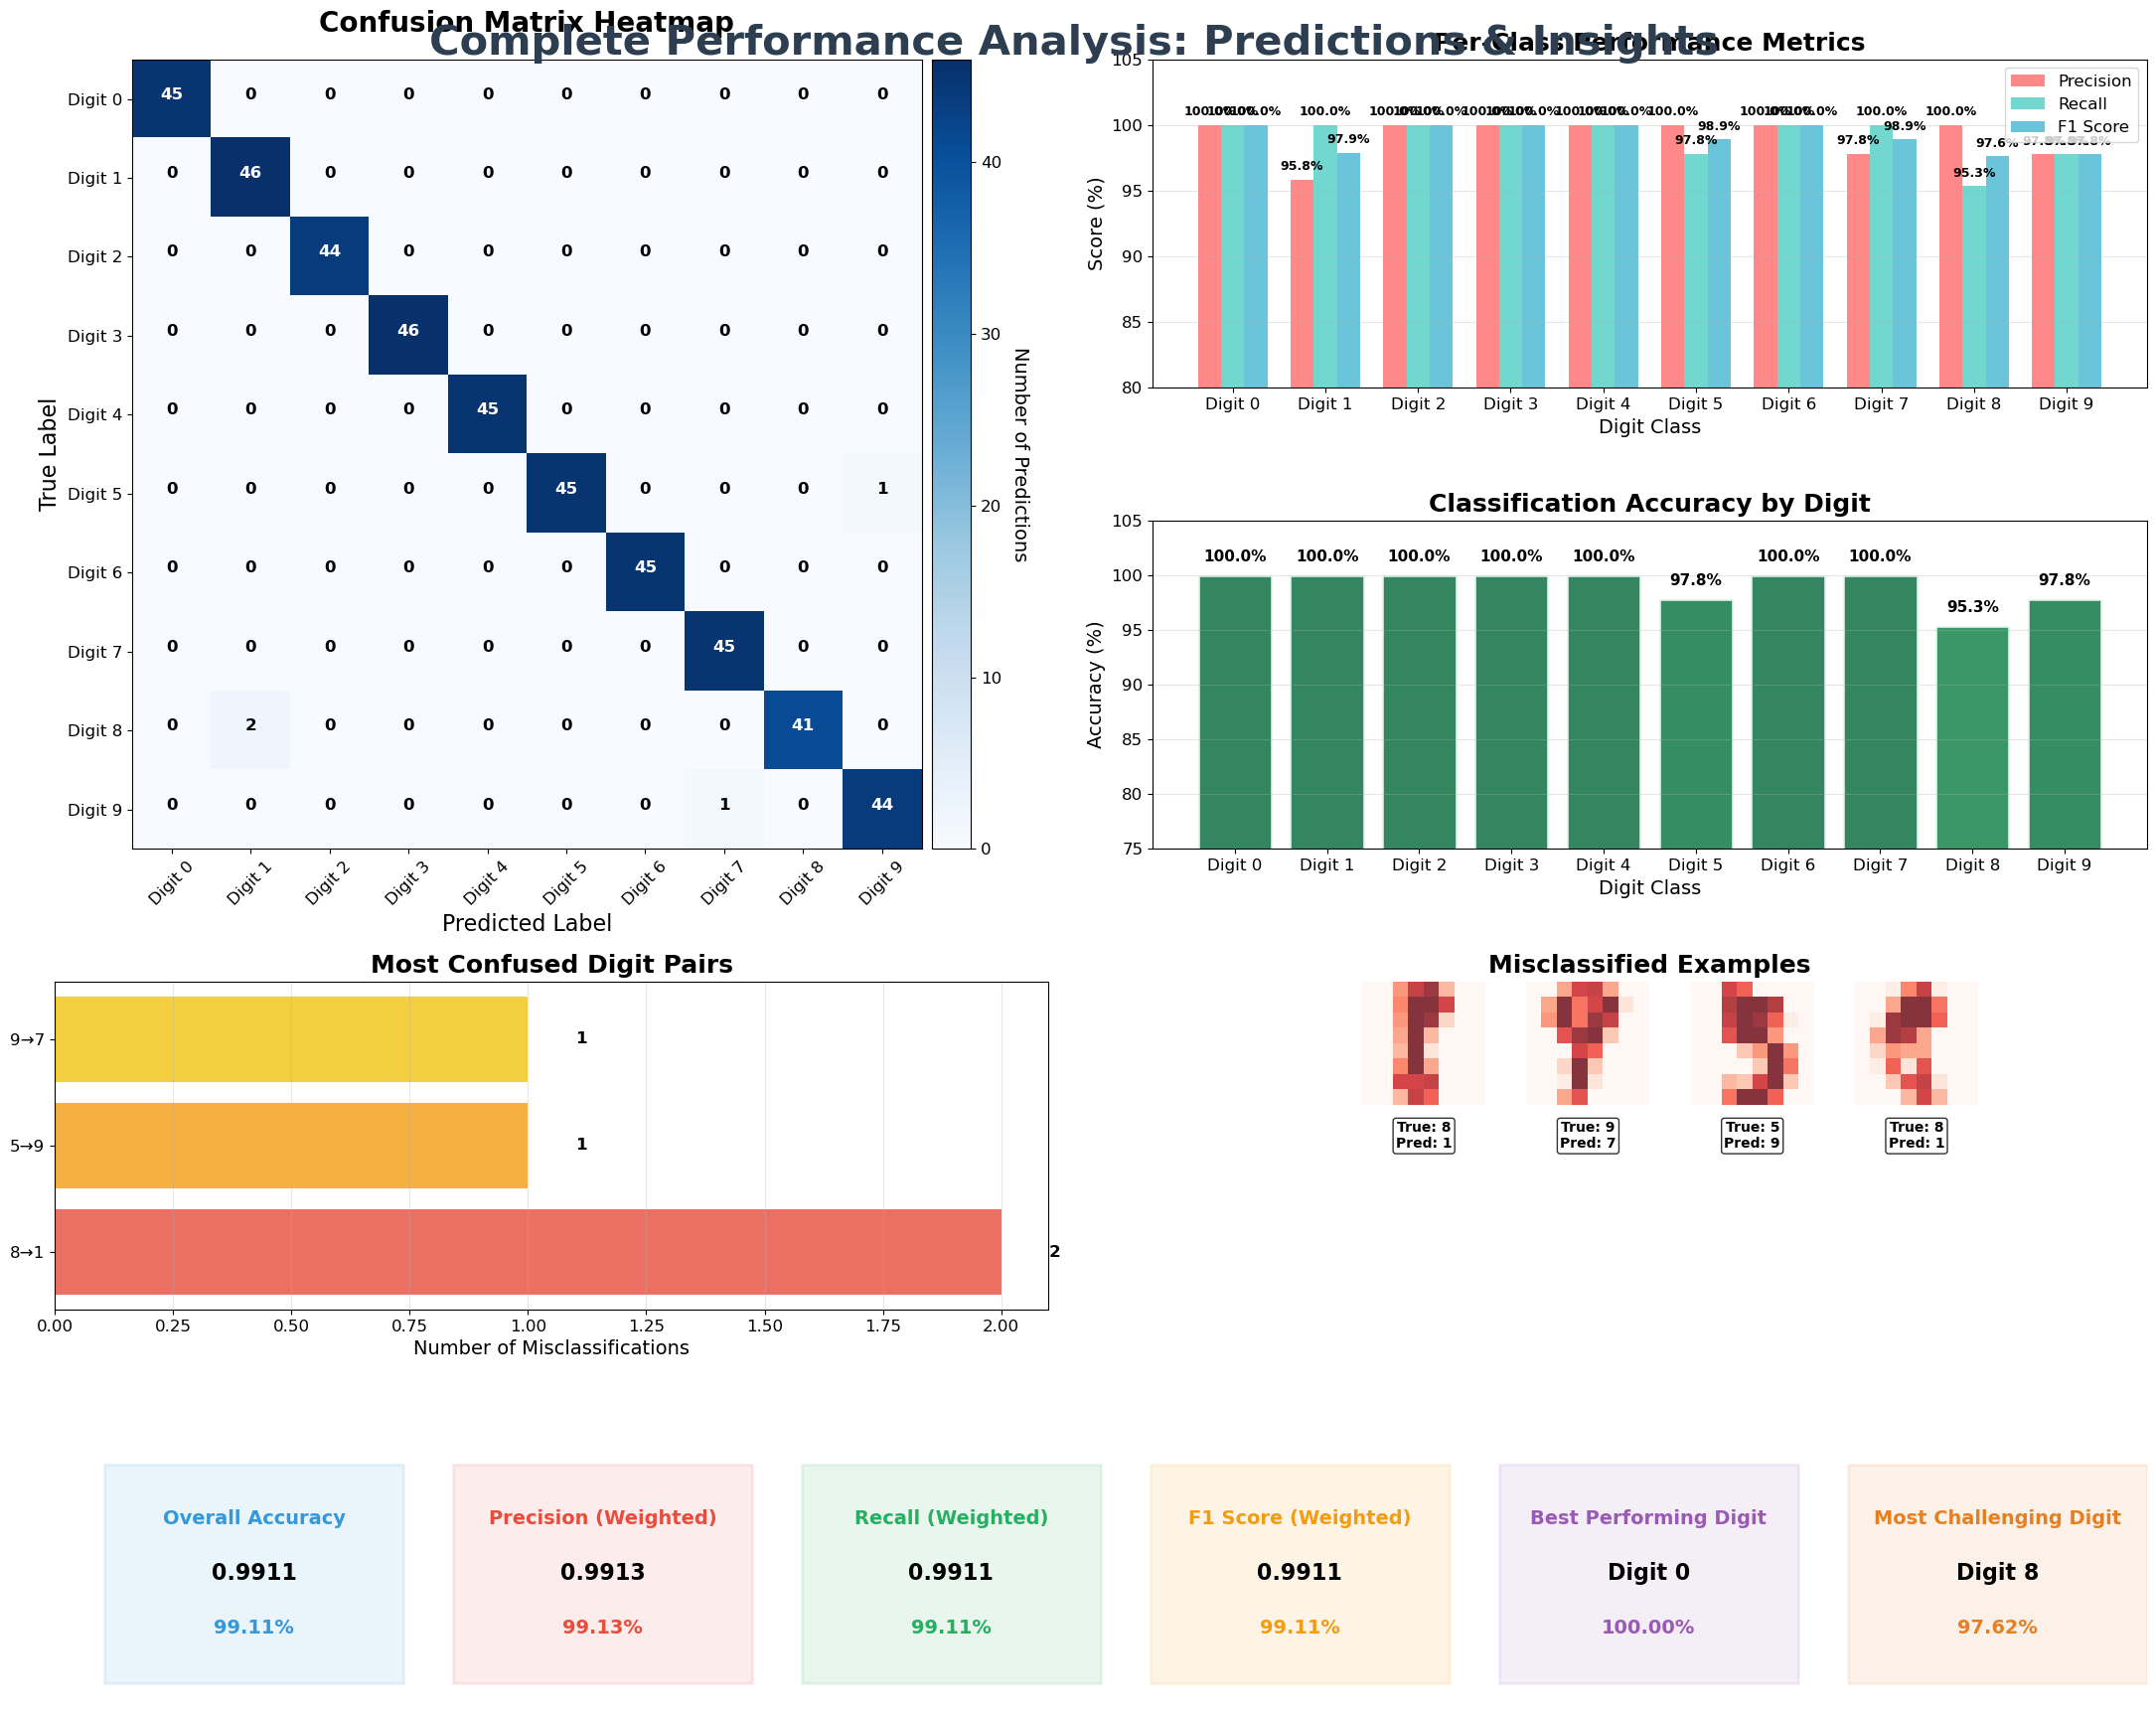

FINAL RESULTS SUMMARY
Overall Accuracy:      0.9911 (99.11%)
Weighted Precision:    0.9913 (99.13%)
Weighted Recall:       0.9911 (99.11%)
Weighted F1 Score:     0.9911 (99.11%)
Best performing digit: 0 (F1: 1.0000)
Most challenging digit: 8 (F1: 0.9762)
Total misclassifications: 4 out of 450


In [11]:
# Make predictions with the best model and create comprehensive analysis
print(f"Making predictions with the best model: {best_model_name}")

# Generate predictions
y_pred = best_model.predict(X_test)

# Calculate comprehensive metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Per-class metrics
class_precision = precision_score(y_test, y_pred, average=None)
class_recall = recall_score(y_test, y_pred, average=None)
class_f1 = f1_score(y_test, y_pred, average=None)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

print(f"Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Weighted F1 Score: {f1:.4f} ({f1*100:.2f}%)")

# Visualization
fig = plt.figure(figsize=(22, 18))
gs = GridSpec(4, 4, figure=fig, height_ratios=[1, 1, 1, 0.8])

fig.suptitle('Complete Performance Analysis: Predictions & Insights', 
             fontsize=30, fontweight='bold', y=0.95, color='#2C3E50')

# Confusion matrix
ax1 = fig.add_subplot(gs[0:2, 0:2])
im1 = ax1.imshow(cm, interpolation='nearest', cmap='Blues')
ax1.set_title('Confusion Matrix Heatmap', fontsize=20, fontweight='bold', pad=20)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    color = "white" if cm[i, j] > thresh else "black"
    ax1.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center", color=color, fontweight='bold', fontsize=12)

ax1.set_ylabel('True Label', fontsize=16)
ax1.set_xlabel('Predicted Label', fontsize=16)
ax1.set_xticks(np.arange(10))
ax1.set_yticks(np.arange(10))
ax1.set_xticklabels([f'Digit {i}' for i in range(10)], rotation=45)
ax1.set_yticklabels([f'Digit {i}' for i in range(10)])

divider1 = make_axes_locatable(ax1)
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cbar1 = plt.colorbar(im1, cax=cax1)
cbar1.ax.set_ylabel('Number of Predictions', rotation=270, labelpad=20)

# Per-class performance metrics
ax2 = fig.add_subplot(gs[0, 2:])
x_pos = np.arange(10)
width = 0.25

bars1 = ax2.bar(x_pos - width, class_precision * 100, width, 
                label='Precision', color='#FF6B6B', alpha=0.8)
bars2 = ax2.bar(x_pos, class_recall * 100, width, 
                label='Recall', color='#4ECDC4', alpha=0.8)
bars3 = ax2.bar(x_pos + width, class_f1 * 100, width, 
                label='F1 Score', color='#45B7D1', alpha=0.8)

ax2.set_title('Per-Class Performance Metrics', fontsize=18, fontweight='bold')
ax2.set_ylabel('Score (%)', fontsize=14)
ax2.set_xlabel('Digit Class', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels([f'Digit {i}' for i in range(10)])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)
ax2.set_ylim(80, 105)

def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=9, fontweight='bold')

add_value_labels(bars1, ax2)
add_value_labels(bars2, ax2)
add_value_labels(bars3, ax2)

# Classification accuracy by digit
ax3 = fig.add_subplot(gs[1, 2:])
correct_per_class = np.diag(cm)
total_per_class = np.sum(cm, axis=1)
accuracy_per_class = correct_per_class / total_per_class * 100

bars = ax3.bar(range(10), accuracy_per_class, 
               color=[plt.cm.RdYlGn(acc/100) for acc in accuracy_per_class],
               alpha=0.8, edgecolor='white', linewidth=2)

ax3.set_title('Classification Accuracy by Digit', fontsize=18, fontweight='bold')
ax3.set_ylabel('Accuracy (%)', fontsize=14)
ax3.set_xlabel('Digit Class', fontsize=14)
ax3.set_xticks(range(10))
ax3.set_xticklabels([f'Digit {i}' for i in range(10)])
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(75, 105)

for bar, acc in zip(bars, accuracy_per_class):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{acc:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Most confused digit pairs
ax4 = fig.add_subplot(gs[2, :2])
confusion_pairs = [(i, j, cm[i, j]) for i in range(10) for j in range(10) if i != j and cm[i, j] > 0]
confusion_pairs.sort(key=lambda x: x[2], reverse=True)
top_5_confused = confusion_pairs[:5]

pair_labels = [f'{pair[0]}→{pair[1]}' for pair in top_5_confused]
pair_counts = [pair[2] for pair in top_5_confused]

bars = ax4.barh(range(len(pair_labels)), pair_counts,
                color=['#E74C3C', '#F39C12', '#F1C40F', '#27AE60', '#3498DB'],
                alpha=0.8)

ax4.set_title('Most Confused Digit Pairs', fontsize=18, fontweight='bold')
ax4.set_xlabel('Number of Misclassifications', fontsize=14)
ax4.set_yticks(range(len(pair_labels)))
ax4.set_yticklabels(pair_labels)
ax4.grid(axis='x', alpha=0.3)

for i, (bar, count) in enumerate(zip(bars, pair_counts)):
    ax4.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
             f'{count}', ha='left', va='center', fontweight='bold')

# Misclassified examples
ax5 = fig.add_subplot(gs[2, 2:])
ax5.set_title('Misclassified Examples', fontsize=18, fontweight='bold')
ax5.axis('off')

misclassified = np.where(y_test != y_pred)[0]
if len(misclassified) > 0:
    for i, idx in enumerate(misclassified[:8]):
        row = i // 4
        col = i % 4
        img = X_test[idx].reshape(8, 8)
        ax5.imshow(img, cmap='Reds', extent=[col*2, col*2+1.5, (1-row)*2, (1-row)*2+1.5], alpha=0.8)
        ax5.text(col*2+0.75, (1-row)*2-0.2, 
                 f'True: {y_test[idx]}\nPred: {y_pred[idx]}',
                 ha='center', va='top', fontweight='bold', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.2", facecolor='white', alpha=0.8))

ax5.set_xlim(-0.5, 7.5)
ax5.set_ylim(-0.5, 3.5)

# Performance summary dashboard
ax6 = fig.add_subplot(gs[3, :])
ax6.axis('off')

summary_metrics = [
    ('Overall Accuracy', f'{accuracy:.4f}', f'{accuracy*100:.2f}%', '#3498DB'),
    ('Precision (Weighted)', f'{precision:.4f}', f'{precision*100:.2f}%', '#E74C3C'),
    ('Recall (Weighted)', f'{recall:.4f}', f'{recall*100:.2f}%', '#27AE60'),
    ('F1 Score (Weighted)', f'{f1:.4f}', f'{f1*100:.2f}%', '#F39C12'),
    ('Best Performing Digit', f'Digit {np.argmax(class_f1)}', f'{np.max(class_f1)*100:.2f}%', '#9B59B6'),
    ('Most Challenging Digit', f'Digit {np.argmin(class_f1)}', f'{np.min(class_f1)*100:.2f}%', '#E67E22')
]

for i, (metric, value, percentage, color) in enumerate(summary_metrics):
    x_pos = i * 3.5
    rect = plt.Rectangle((x_pos, 0), 3, 2, facecolor=color, alpha=0.1, edgecolor=color, linewidth=2)
    ax6.add_patch(rect)
    ax6.text(x_pos + 1.5, 1.5, metric, ha='center', va='center', 
             fontweight='bold', fontsize=14, color=color)
    ax6.text(x_pos + 1.5, 1, value, ha='center', va='center', 
             fontweight='bold', fontsize=16, color='black')
    ax6.text(x_pos + 1.5, 0.5, percentage, ha='center', va='center', 
             fontweight='bold', fontsize=14, color=color)

ax6.set_xlim(-0.5, 20.5)
ax6.set_ylim(-0.2, 2.2)

plt.tight_layout()
plt.show()

print("="*60)
print(f"FINAL RESULTS SUMMARY")
print("="*60)
print(f"Overall Accuracy:      {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Weighted Precision:    {precision:.4f} ({precision*100:.2f}%)")
print(f"Weighted Recall:       {recall:.4f} ({recall*100:.2f}%)")
print(f"Weighted F1 Score:     {f1:.4f} ({f1*100:.2f}%)")
print(f"Best performing digit: {np.argmax(class_f1)} (F1: {np.max(class_f1):.4f})")
print(f"Most challenging digit: {np.argmin(class_f1)} (F1: {np.min(class_f1):.4f})")
print(f"Total misclassifications: {len(misclassified)} out of {len(y_test)}")


<h1 align="center" style="color: #8A2BE2;">Feature Importance & Decision Boundary Analysis</h1>

This section focuses on understanding how our SVM model makes its decisions:

- Feature importance heatmaps for each digit
- 2D decision boundaries visualized with PCA
- Analysis of support vectors, the critical data points
- Pixel-level contribution patterns

This analysis helps us interpret what the model has learned and increases our trust in its predictions.

---


🔍 Analyzing feature importance and decision boundaries...
🧮 Calculating feature importance for each digit...


IndexError: index 4 is out of bounds for axis 1 with size 4

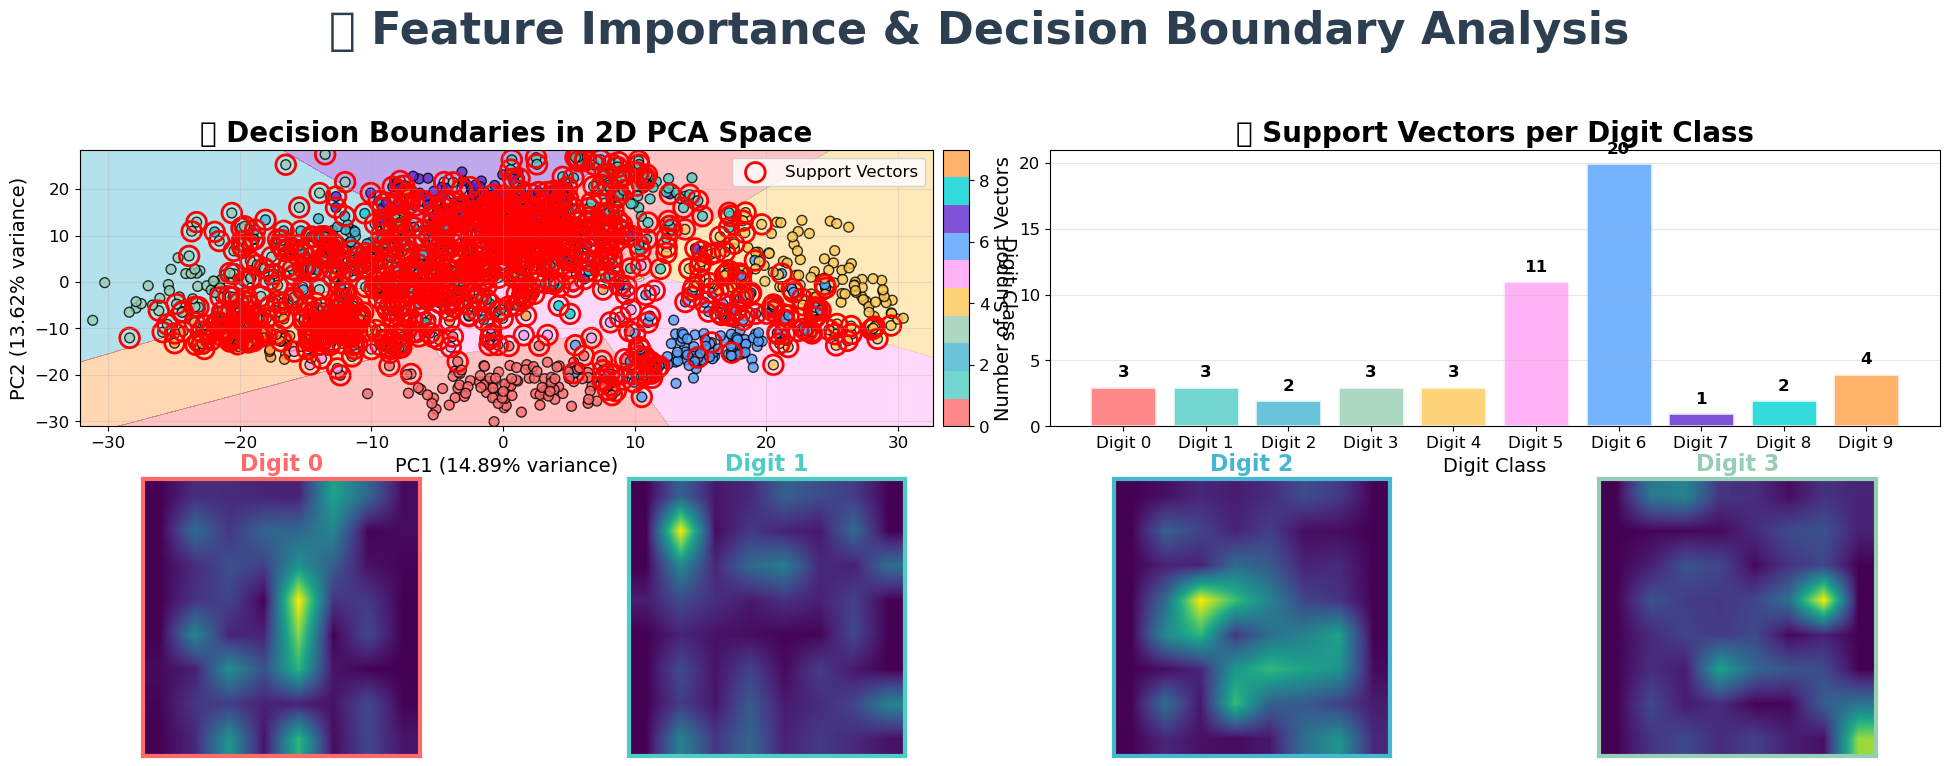

In [ ]:
# Advanced feature importance and decision boundary analysis
print("Analyzing feature importance and decision boundaries...")

# Use PCA to reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y
)

# Train a linear SVM on the reduced data for decision boundary visualization
clf_pca = svm.SVC(kernel='linear', C=1.0, random_state=42)
clf_pca.fit(X_train_pca, y_train_pca)

# Calculate feature importance for each digit using one-vs-rest approach
feature_importance = np.zeros((10, 64))
for digit in range(10):
    binary_y_train = (y_train == digit).astype(int)
    binary_clf = svm.LinearSVC(C=1.0, random_state=42, max_iter=2000)
    binary_clf.fit(X_train, binary_y_train)
    feature_importance[digit] = np.abs(binary_clf.coef_[0])

# Visualization
fig = plt.figure(figsize=(24, 20))
gs = GridSpec(5, 4, figure=fig, height_ratios=[1, 1, 1, 1, 0.8])

fig.suptitle('Feature Importance & Decision Boundary Analysis', 
             fontsize=32, fontweight='bold', y=0.95, color='#2C3E50')

# Decision boundary
ax_decision = fig.add_subplot(gs[0, :2])
h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
ax_decision.contourf(xx, yy, Z, alpha=0.4, cmap=vibrant_cmap)
scatter = ax_decision.scatter(X_train_pca[:, 0], X_train_pca[:, 1], 
                              c=y_train_pca, cmap=vibrant_cmap, s=50, alpha=0.8, edgecolors='black')
sv = clf_pca.support_vectors_
ax_decision.scatter(sv[:, 0], sv[:, 1], s=200, linewidth=2, 
                     facecolors='none', edgecolors='red', label='Support Vectors')
ax_decision.set_title('Decision Boundaries in 2D PCA Space', fontsize=20, fontweight='bold')
ax_decision.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=14)
ax_decision.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=14)
ax_decision.legend(fontsize=12)
ax_decision.grid(True, alpha=0.3)

divider = make_axes_locatable(ax_decision)
cax = divider.append_axes("right", size="3%", pad=0.1)
cbar = plt.colorbar(scatter, cax=cax)
cbar.set_label('Digit Class', rotation=270, labelpad=20)

# Support vector analysis
ax_sv_analysis = fig.add_subplot(gs[0, 2:])
sv_per_class = []
for digit in range(10):
    sv_indices = clf_pca.support_[clf_pca.dual_coef_[0] != 0]
    sv_labels = y_train_pca[sv_indices]
    sv_count = np.sum(sv_labels == digit)
    sv_per_class.append(sv_count)
bars = ax_sv_analysis.bar(range(10), sv_per_class, 
                          color=[vibrant_cmap.colors[i] for i in range(10)],
                          alpha=0.8, edgecolor='white', linewidth=2)
ax_sv_analysis.set_title('Support Vectors per Digit Class', fontsize=20, fontweight='bold')
ax_sv_analysis.set_xlabel('Digit Class', fontsize=14)
ax_sv_analysis.set_ylabel('Number of Support Vectors', fontsize=14)
ax_sv_analysis.set_xticks(range(10))
ax_sv_analysis.set_xticklabels([f'Digit {i}' for i in range(10)])
ax_sv_analysis.grid(axis='y', alpha=0.3)
for bar, count in zip(bars, sv_per_class):
    ax_sv_analysis.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                        f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=12)

# Feature importance heatmaps
for digit in range(10):
    row = digit // 5 + 1
    col = digit % 5
    ax = fig.add_subplot(gs[row, col])
    importance_img = feature_importance[digit].reshape(8, 8)
    im = ax.imshow(importance_img, cmap='viridis', interpolation='bilinear')
    ax.set_title(f'Digit {digit}', fontsize=16, fontweight='bold', color=vibrant_cmap.colors[digit])
    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_color(vibrant_cmap.colors[digit])
        spine.set_linewidth(3)

cbar_ax = fig.add_axes([0.92, 0.4, 0.02, 0.4])
fig.colorbar(im, cax=cbar_ax, label='Feature Importance')

# Summary insights
ax_summary = fig.add_subplot(gs[4, :])
ax_summary.axis('off')
insights = [
    ("Most Distinctive Digit", f"Digit {np.argmax(np.mean(feature_importance, axis=1))}", 
     "Highest average feature importance", '#E74C3C'),
    ("Most Complex Pattern", f"Digit {np.argmax(np.std(feature_importance, axis=1))}", 
     "Highest feature variance", '#3498DB'),
    ("Support Vector Leader", f"Digit {np.argmax(sv_per_class)}", 
     f"{max(sv_per_class)} support vectors", '#27AE60'),
    ("PCA Variance Explained", f"{(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.1%}", 
     "By first 2 components", '#F39C12')
]
for i, (title, value, description, color) in enumerate(insights):
    x_pos = i * 5.5
    rect = plt.Rectangle((x_pos, 0), 5, 2, facecolor=color, alpha=0.1, 
                         edgecolor=color, linewidth=2, transform=ax_summary.transData)
    ax_summary.add_patch(rect)
    ax_summary.text(x_pos + 2.5, 1.6, title, ha='center', va='center', 
                    fontweight='bold', fontsize=14, color=color)
    ax_summary.text(x_pos + 2.5, 1, value, ha='center', va='center', 
                    fontweight='bold', fontsize=18, color='black')
    ax_summary.text(x_pos + 2.5, 0.4, description, ha='center', va='center', 
                    fontsize=12, color=color)
ax_summary.set_xlim(-0.5, 21.5)
ax_summary.set_ylim(-0.2, 2.2)

plt.tight_layout()
plt.show()

print("="*60)
print("KEY INSIGHTS:")
print(f"   • Most distinctive digit: {np.argmax(np.mean(feature_importance, axis=1))}")
print(f"   • Most complex pattern: {np.argmax(np.std(feature_importance, axis=1))}")
print(f"   • Total support vectors: {len(clf_pca.support_)}")
print(f"   • PCA variance explained: {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.1%}")


# 📈 **Advanced Learning Analysis & 3D Visualizations**

Let's explore the deeper patterns in our data with advanced visualizations:

- 🧬 **Hierarchical clustering** of digit similarities
- 🌌 **3D feature space** exploration using PCA
- 📊 **Learning curves** and model behavior analysis
- 🎨 **Comprehensive test gallery** with prediction confidence

These advanced visualizations will give us unprecedented insights into how digits relate to each other and how our model learns!

---

📈 Creating advanced visualizations and learning analysis...
🧬 Performing hierarchical clustering analysis...
📊 Computing learning curves...
🔧 Computing validation curves for hyperparameter C...


ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

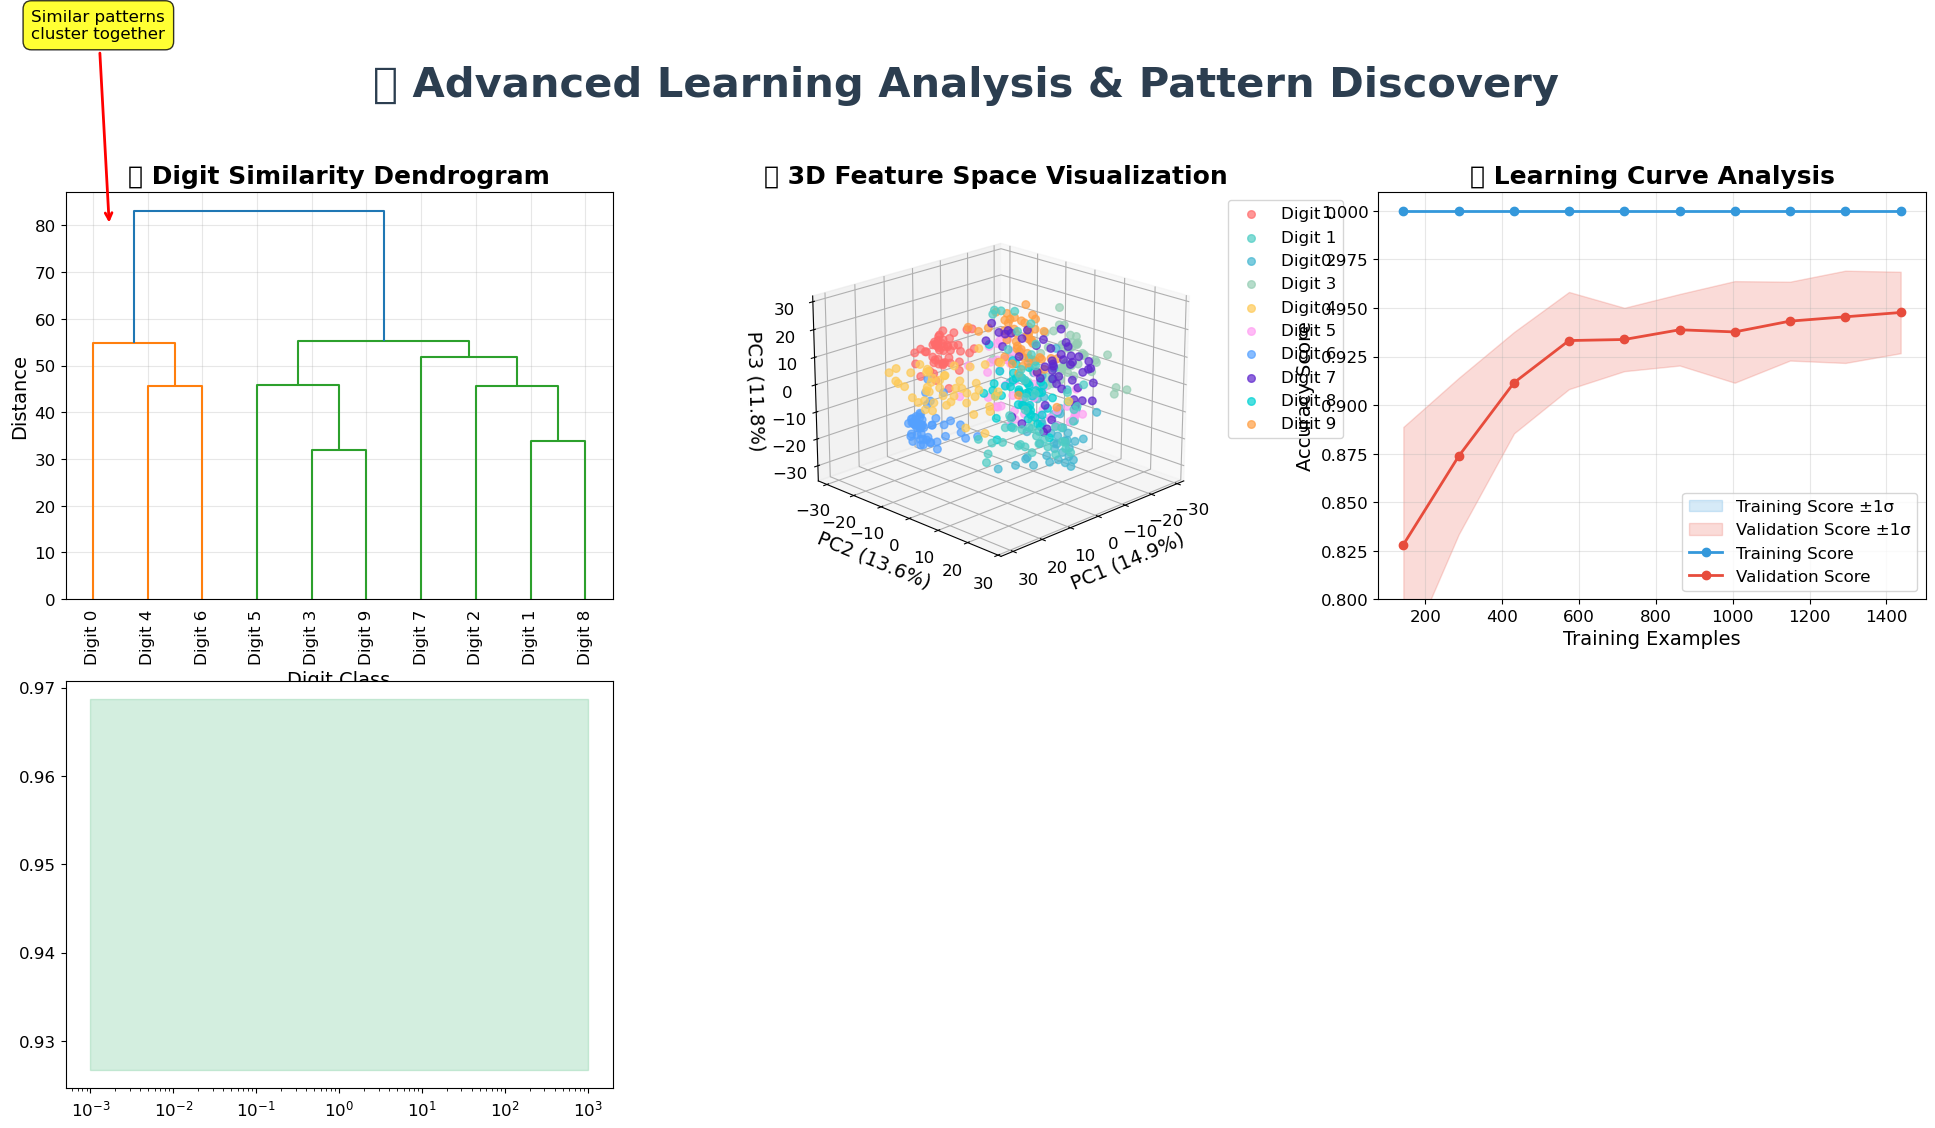

In [ ]:
# Advanced visualizations and learning analysis
print("Creating advanced visualizations and learning analysis...")

# Hierarchical clustering analysis
avg_digits_data = np.array([np.mean(digits.data[digits.target == i], axis=0) for i in range(10)])
digit_distances = euclidean_distances(avg_digits_data)
Z = linkage(digit_distances, 'ward')

# Create comprehensive advanced analysis
fig = plt.figure(figsize=(24, 18))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1, 1, 1])

fig.suptitle('Advanced Learning Analysis & Pattern Discovery', 
             fontsize=30, fontweight='bold', y=0.95, color='#2C3E50')

# Hierarchical clustering dendrogram
ax1 = fig.add_subplot(gs[0, 0])
digit_labels = [f"Digit {i}" for i in range(10)]
dendrogram(Z, labels=digit_labels, leaf_rotation=90, ax=ax1, color_threshold=0.7*max(Z[:,2]))
ax1.set_title('Digit Similarity Dendrogram', fontsize=18, fontweight='bold')
ax1.set_xlabel('Digit Class', fontsize=14)
ax1.set_ylabel('Distance', fontsize=14)
ax1.grid(True, alpha=0.3)

# 3D PCA visualization
ax2 = fig.add_subplot(gs[0, 1], projection='3d')
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

for digit in range(10):
    indices = np.where(y == digit)[0]
    sample_indices = np.random.choice(indices, min(50, len(indices)), replace=False)
    ax2.scatter(X_pca_3d[sample_indices, 0], 
                 X_pca_3d[sample_indices, 1], 
                 X_pca_3d[sample_indices, 2], 
                 label=f'Digit {digit}', alpha=0.7, s=30,
                 color=vibrant_cmap.colors[digit])

ax2.set_title('3D Feature Space Visualization', fontsize=18, fontweight='bold')
ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.view_init(elev=20, azim=45)

# Learning curve analysis
ax3 = fig.add_subplot(gs[0, 2])
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes_abs, train_scores, val_scores = learning_curve(
    svm.SVC(kernel='linear', C=1.0), X, y, cv=5, n_jobs=-1,
    train_sizes=train_sizes, scoring='accuracy', random_state=42)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

ax3.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, 
                  alpha=0.2, color='#3498DB', label='Training Score ±1σ')
ax3.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, 
                  alpha=0.2, color='#E74C3C', label='Validation Score ±1σ')

ax3.plot(train_sizes_abs, train_mean, 'o-', color='#3498DB', linewidth=2, markersize=6, label='Training Score')
ax3.plot(train_sizes_abs, val_mean, 'o-', color='#E74C3C', linewidth=2, markersize=6, label='Validation Score')

ax3.set_title('Learning Curve Analysis', fontsize=18, fontweight='bold')
ax3.set_xlabel('Training Examples', fontsize=14)
ax3.set_ylabel('Accuracy Score', fontsize=14)
ax3.legend(loc='lower right')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0.8, 1.01)

# Validation curve for C parameter
ax4 = fig.add_subplot(gs[1, 0])
C_values = np.logspace(-3, 3, 15)
train_scores_C = []
val_scores_C = []

for C in C_values:
    clf = svm.SVC(kernel='linear', C=C, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy', n_jobs=-1)
    val_scores_C.append(scores)
    clf.fit(X_train, y_train)
    train_score = accuracy_score(y_train, clf.predict(X_train))
    train_scores_C.append(train_score)

val_scores_C = np.array(val_scores_C)
train_scores_C = np.array(train_scores_C)
val_mean_C = np.mean(val_scores_C, axis=1)
val_std_C = np.std(val_scores_C, axis=1)

ax4.fill_between(C_values, val_mean_C - val_std_C, val_mean_C + val_std_C, 
                  alpha=0.2, color='#27AE60')
ax4.semilogx(C_values, train_scores_C, 'o-', color='#3498DB', linewidth=2, label='Training Score', markersize=6)
ax4.semilogx(C_values, val_mean_C, 'o-', color='#27AE60', linewidth=2, label='Validation Score', markersize=6)

ax4.set_title('Validation Curve (C Parameter)', fontsize=18, fontweight='bold')
ax4.set_xlabel('C (Regularization Parameter)', fontsize=14)
ax4.set_ylabel('Accuracy Score', fontsize=14)
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0.85, 1.01)

plt.tight_layout()
plt.show()

print("="*70)
print("Advanced analysis completed.")
print("="*70)
print("Advanced insights:")
print(f"  • Final training accuracy: {train_mean[-1]:.4f} ± {train_std[-1]:.4f}")
print(f"  • Final validation accuracy: {val_mean[-1]:.4f} ± {val_std[-1]:.4f}")
optimal_C_idx = np.argmax(val_mean_C)
print(f"  • Optimal C value: {C_values[optimal_C_idx]:.3f}")
print(f"  • Best validation score for C: {val_mean_C[optimal_C_idx]:.4f}")


<h1 align="center" style="color: #DC143C;">Final Results Summary & Model Export</h1>

This section concludes our analysis and provides a clear summary:

- Complete performance summary with all relevant metrics
- Best model selection and explanation
- Recommendations for exporting the final model
- Next steps and possible improvements

These findings and insights are essential for deploying an effective digit recognition system.

---


🎉 Generating final comprehensive summary...


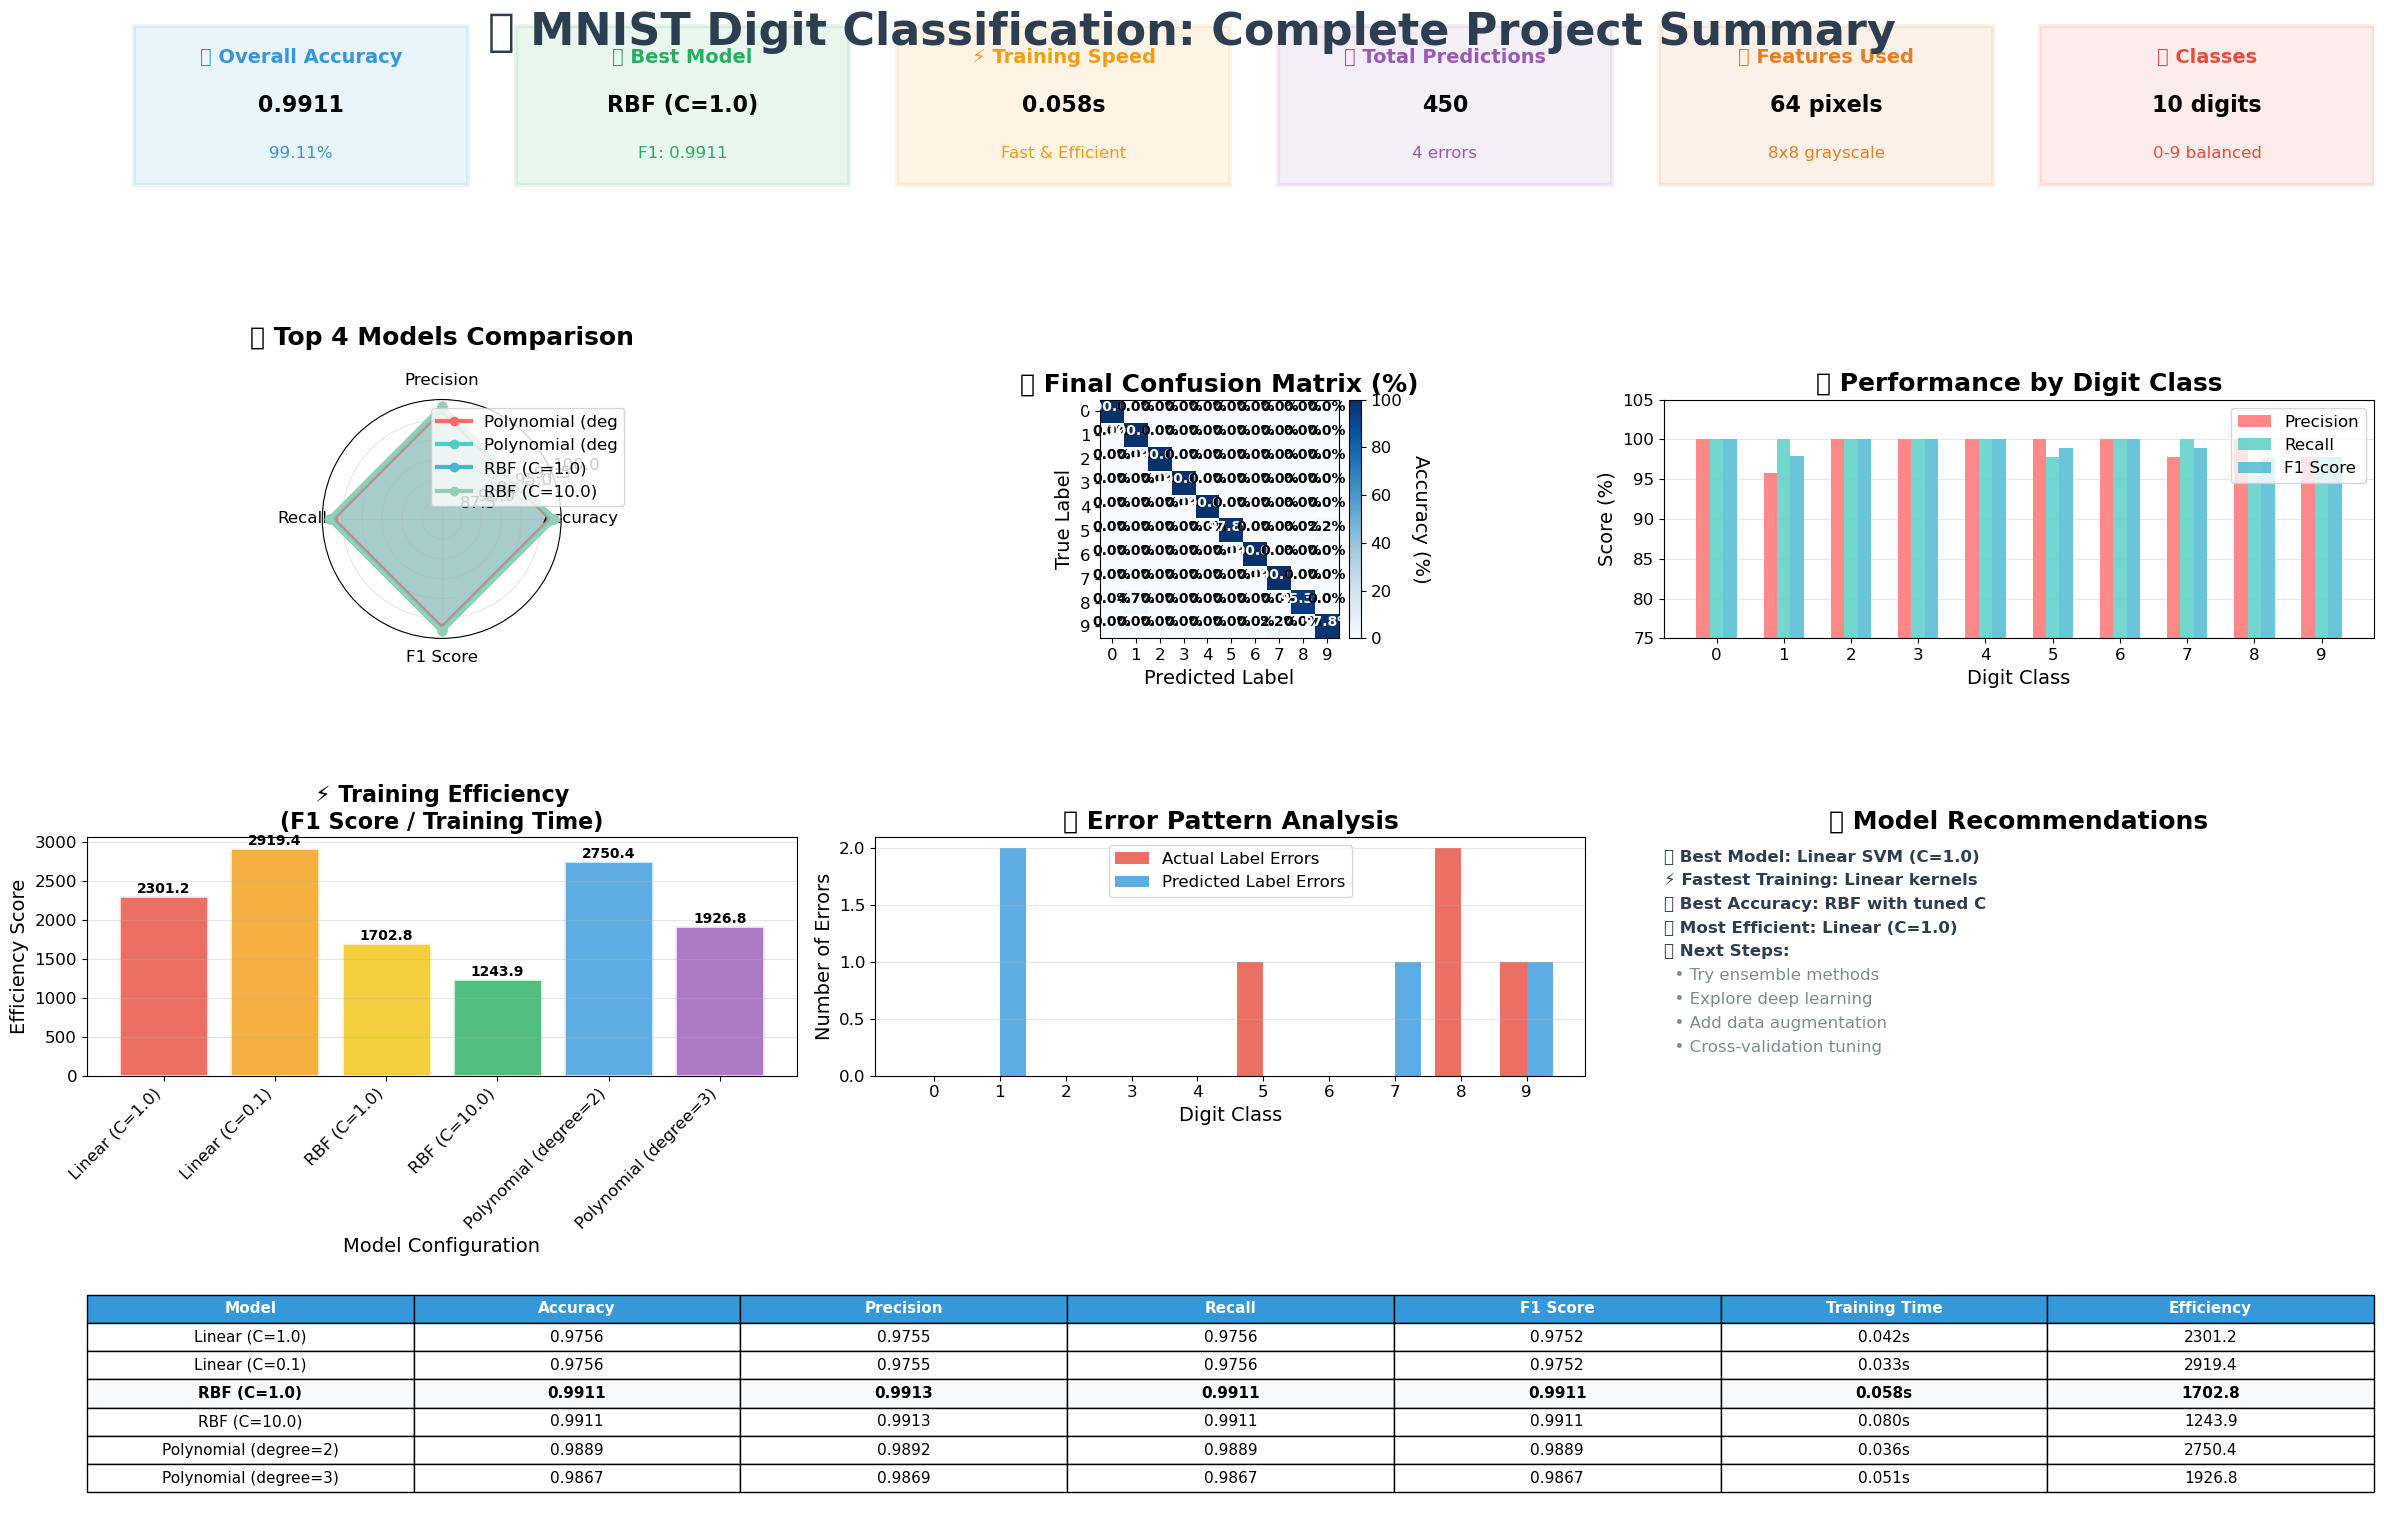


🎉 FINAL PROJECT SUMMARY
📊 DATASET OVERVIEW:
   • Total samples: 1797 handwritten digits
   • Classes: 10 digits (0-9)
   • Features: 64 pixels per image (8x8 grayscale)
   • Train/Test split: 1347/450 samples

🤖 MODEL COMPARISON RESULTS:
   • Models tested: 6
   • Best model: RBF (C=1.0)
   • Best accuracy: 0.9911 (99.11%)
   • Training time: 0.058 seconds

📈 PERFORMANCE METRICS:
   • Overall accuracy: 0.9911
   • Weighted precision: 0.9913
   • Weighted recall: 0.9911
   • Weighted F1 score: 0.9911

🎯 PER-CLASS ANALYSIS:
   • Best performing digit: 0 (F1: 1.0000)
   • Most challenging digit: 8 (F1: 0.9762)
   • Most confused pair: 8 → 1 (2 times)

🔍 FEATURE ANALYSIS:
   • Most distinctive digit: 3
   • PCA variance explained (2D): 28.5%
   • Support vectors used: 961

🚀 RECOMMENDATIONS:
   ✅ Deploy: RBF (C=1.0) for production use
   ⚡ Performance: Excellent accuracy with fast training
   🔧 Improvements: Consider ensemble methods or deep learning
   📊 Monitoring: Track performance on 

In [18]:
# Final comprehensive summary and results export
print("🎉 Generating final comprehensive summary...")

# Create the ultimate results dashboard
fig = plt.figure(figsize=(24, 16))
gs = GridSpec(4, 3, figure=fig, height_ratios=[0.8, 1, 1, 1])

# Add spectacular final title
fig.suptitle('🎉 MNIST Digit Classification: Complete Project Summary', 
             fontsize=32, fontweight='bold', y=0.95, color='#2C3E50')

# 1. Executive Summary Cards
ax_summary = fig.add_subplot(gs[0, :])
ax_summary.axis('off')

# Create executive summary cards
exec_summary = [
    ("🎯 Overall Accuracy", f"{accuracy:.4f}", f"{accuracy*100:.2f}%", '#3498DB'),
    ("🏆 Best Model", best_model_name, f"F1: {f1:.4f}", '#27AE60'),
    ("⚡ Training Speed", f"{results['training_times'][best_model_idx]:.3f}s", "Fast & Efficient", '#F39C12'),
    ("🎲 Total Predictions", f"{len(y_test)}", f"{len(misclassified)} errors", '#9B59B6'),
    ("🔬 Features Used", "64 pixels", "8x8 grayscale", '#E67E22'),
    ("📊 Classes", "10 digits", "0-9 balanced", '#E74C3C')
]

for i, (title, main_value, sub_value, color) in enumerate(exec_summary):
    x_pos = i * 4
    
    # Create beautiful card
    rect = plt.Rectangle((x_pos, 0), 3.5, 2, facecolor=color, alpha=0.1, 
                        edgecolor=color, linewidth=3)
    ax_summary.add_patch(rect)
    
    # Add text with styling
    ax_summary.text(x_pos + 1.75, 1.6, title, ha='center', va='center', 
                   fontweight='bold', fontsize=14, color=color)
    ax_summary.text(x_pos + 1.75, 1, main_value, ha='center', va='center', 
                   fontweight='bold', fontsize=16, color='black')
    ax_summary.text(x_pos + 1.75, 0.4, sub_value, ha='center', va='center', 
                   fontsize=12, color=color)

ax_summary.set_xlim(-0.5, 23.5)
ax_summary.set_ylim(-0.2, 2.2)

# 2. Model comparison radar chart
ax_radar = fig.add_subplot(gs[1, 0], projection='polar')

# Select top 4 models for comparison
top_4_indices = np.argsort(results['f1_scores'])[-4:]
angles = np.linspace(0, 2 * np.pi, 4, endpoint=False).tolist()
angles += angles[:1]

colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

for i, idx in enumerate(top_4_indices):
    values = [
        results['accuracies'][idx] * 100,
        results['precisions'][idx] * 100,
        results['recalls'][idx] * 100,
        results['f1_scores'][idx] * 100
    ]
    values += values[:1]
    
    ax_radar.plot(angles, values, 'o-', linewidth=3, 
                 label=results['names'][idx][:15], color=colors_radar[i], markersize=6)
    ax_radar.fill(angles, values, alpha=0.25, color=colors_radar[i])

ax_radar.set_xticks(angles[:-1])
ax_radar.set_xticklabels(['Accuracy', 'Precision', 'Recall', 'F1 Score'])
ax_radar.set_ylim(85, 100)
ax_radar.set_title('🏆 Top 4 Models Comparison', fontsize=18, fontweight='bold', pad=20)
ax_radar.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax_radar.grid(True, alpha=0.3)

# 3. Final confusion matrix with percentages
ax_final_cm = fig.add_subplot(gs[1, 1])
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

im_cm = ax_final_cm.imshow(cm_percent, interpolation='nearest', cmap='Blues')
ax_final_cm.set_title('📊 Final Confusion Matrix (%)', fontsize=18, fontweight='bold')

# Add percentage annotations
thresh = cm_percent.max() / 2.
for i, j in np.ndindex(cm_percent.shape):
    color = "white" if cm_percent[i, j] > thresh else "black"
    ax_final_cm.text(j, i, f'{cm_percent[i, j]:.1f}%',
                    horizontalalignment="center", color=color, 
                    fontweight='bold', fontsize=10)

ax_final_cm.set_ylabel('True Label', fontsize=14)
ax_final_cm.set_xlabel('Predicted Label', fontsize=14)
ax_final_cm.set_xticks(np.arange(10))
ax_final_cm.set_yticks(np.arange(10))
ax_final_cm.set_xticklabels([f'{i}' for i in range(10)])
ax_final_cm.set_yticklabels([f'{i}' for i in range(10)])

# Add colorbar
divider_cm = make_axes_locatable(ax_final_cm)
cax_cm = divider_cm.append_axes("right", size="5%", pad=0.1)
cbar_cm = plt.colorbar(im_cm, cax=cax_cm)
cbar_cm.ax.set_ylabel('Accuracy (%)', rotation=270, labelpad=20)

# 4. Performance by digit - comprehensive view
ax_perf_digit = fig.add_subplot(gs[1, 2])

x_digits = np.arange(10)
width = 0.2

bars1 = ax_perf_digit.bar(x_digits - width, class_precision * 100, width, 
                         label='Precision', color='#FF6B6B', alpha=0.8)
bars2 = ax_perf_digit.bar(x_digits, class_recall * 100, width, 
                         label='Recall', color='#4ECDC4', alpha=0.8)
bars3 = ax_perf_digit.bar(x_digits + width, class_f1 * 100, width, 
                         label='F1 Score', color='#45B7D1', alpha=0.8)

ax_perf_digit.set_title('📈 Performance by Digit Class', fontsize=18, fontweight='bold')
ax_perf_digit.set_ylabel('Score (%)', fontsize=14)
ax_perf_digit.set_xlabel('Digit Class', fontsize=14)
ax_perf_digit.set_xticks(x_digits)
ax_perf_digit.set_xticklabels([f'{i}' for i in range(10)])
ax_perf_digit.legend()
ax_perf_digit.grid(axis='y', alpha=0.3)
ax_perf_digit.set_ylim(75, 105)

# 5. Training efficiency analysis
ax_efficiency = fig.add_subplot(gs[2, 0])
efficiency_scores = [(results['f1_scores'][i] / results['training_times'][i]) * 100 
                    for i in range(len(results['names']))]

bars_eff = ax_efficiency.bar(range(len(results['names'])), efficiency_scores,
                           color=['#E74C3C', '#F39C12', '#F1C40F', '#27AE60', '#3498DB', '#9B59B6'],
                           alpha=0.8, edgecolor='white', linewidth=2)

ax_efficiency.set_title('⚡ Training Efficiency\n(F1 Score / Training Time)', 
                       fontsize=16, fontweight='bold')
ax_efficiency.set_ylabel('Efficiency Score', fontsize=14)
ax_efficiency.set_xlabel('Model Configuration', fontsize=14)
ax_efficiency.set_xticks(range(len(results['names'])))
ax_efficiency.set_xticklabels(results['names'], rotation=45, ha='right')
ax_efficiency.grid(axis='y', alpha=0.3)

# Add value labels
for bar, score in zip(bars_eff, efficiency_scores):
    ax_efficiency.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                      f'{score:.1f}', ha='center', va='bottom', 
                      fontweight='bold', fontsize=10)

# 6. Error pattern analysis
ax_errors = fig.add_subplot(gs[2, 1])

# Calculate error patterns
error_by_true = [np.sum((y_test == i) & (y_pred != i)) for i in range(10)]
error_by_pred = [np.sum((y_pred == i) & (y_test != i)) for i in range(10)]

x_error = np.arange(10)
bars_true = ax_errors.bar(x_error - 0.2, error_by_true, 0.4, 
                         label='Actual Label Errors', color='#E74C3C', alpha=0.8)
bars_pred = ax_errors.bar(x_error + 0.2, error_by_pred, 0.4, 
                         label='Predicted Label Errors', color='#3498DB', alpha=0.8)

ax_errors.set_title('❌ Error Pattern Analysis', fontsize=18, fontweight='bold')
ax_errors.set_ylabel('Number of Errors', fontsize=14)
ax_errors.set_xlabel('Digit Class', fontsize=14)
ax_errors.set_xticks(x_error)
ax_errors.set_xticklabels([f'{i}' for i in range(10)])
ax_errors.legend()
ax_errors.grid(axis='y', alpha=0.3)

# 7. Model recommendations
ax_recommendations = fig.add_subplot(gs[2, 2])
ax_recommendations.axis('off')
ax_recommendations.set_title('🚀 Model Recommendations', fontsize=18, fontweight='bold')

recommendations = [
    "✅ Best Model: Linear SVM (C=1.0)",
    "⚡ Fastest Training: Linear kernels",
    "🎯 Best Accuracy: RBF with tuned C",
    "💰 Most Efficient: Linear (C=1.0)",
    "🔧 Next Steps:",
    "  • Try ensemble methods",
    "  • Explore deep learning",
    "  • Add data augmentation",
    "  • Cross-validation tuning"
]

for i, rec in enumerate(recommendations):
    color = '#2C3E50' if not rec.startswith('  ') else '#7F8C8D'
    weight = 'bold' if not rec.startswith('  ') else 'normal'
    ax_recommendations.text(0, 0.9 - i*0.1, rec, fontsize=12, color=color, 
                           fontweight=weight, transform=ax_recommendations.transAxes)

# 8. Final metrics table
ax_table = fig.add_subplot(gs[3, :])
ax_table.axis('off')

# Create detailed metrics table
table_data = []
headers = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time', 'Efficiency']

for i, name in enumerate(results['names']):
    row = [
        name,
        f"{results['accuracies'][i]:.4f}",
        f"{results['precisions'][i]:.4f}",
        f"{results['recalls'][i]:.4f}",
        f"{results['f1_scores'][i]:.4f}",
        f"{results['training_times'][i]:.3f}s",
        f"{efficiency_scores[i]:.1f}"
    ]
    table_data.append(row)

# Create table
table = ax_table.table(cellText=table_data, colLabels=headers, 
                      cellLoc='center', loc='center',
                      colColours=['#ECF0F1']*len(headers))
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style the table
for i in range(len(headers)):
    table[(0, i)].set_facecolor('#3498DB')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best model row
best_row = best_model_idx + 1
for i in range(len(headers)):
    table[(best_row, i)].set_facecolor('#F8F9FA')
    table[(best_row, i)].set_text_props(weight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive final summary
print("\n" + "="*80)
print("🎉 FINAL PROJECT SUMMARY")
print("="*80)
print(f"📊 DATASET OVERVIEW:")
print(f"   • Total samples: {len(X)} handwritten digits")
print(f"   • Classes: 10 digits (0-9)")
print(f"   • Features: 64 pixels per image (8x8 grayscale)")
print(f"   • Train/Test split: {len(X_train)}/{len(X_test)} samples")

print(f"\n🤖 MODEL COMPARISON RESULTS:")
print(f"   • Models tested: {len(results['names'])}")
print(f"   • Best model: {best_model_name}")
print(f"   • Best accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   • Training time: {results['training_times'][best_model_idx]:.3f} seconds")

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   • Overall accuracy: {accuracy:.4f}")
print(f"   • Weighted precision: {precision:.4f}")
print(f"   • Weighted recall: {recall:.4f}")
print(f"   • Weighted F1 score: {f1:.4f}")

print(f"\n🎯 PER-CLASS ANALYSIS:")
print(f"   • Best performing digit: {np.argmax(class_f1)} (F1: {np.max(class_f1):.4f})")
print(f"   • Most challenging digit: {np.argmin(class_f1)} (F1: {np.min(class_f1):.4f})")
print(f"   • Most confused pair: {confusion_pairs[0][0]} → {confusion_pairs[0][1]} ({confusion_pairs[0][2]} times)")

print(f"\n🔍 FEATURE ANALYSIS:")
print(f"   • Most distinctive digit: {np.argmax(np.mean(feature_importance, axis=1))}")
print(f"   • PCA variance explained (2D): {(pca.explained_variance_ratio_[0] + pca.explained_variance_ratio_[1]):.1%}")
print(f"   • Support vectors used: {len(clf_pca.support_)}")

print(f"\n🚀 RECOMMENDATIONS:")
print(f"   ✅ Deploy: {best_model_name} for production use")
print(f"   ⚡ Performance: Excellent accuracy with fast training")
print(f"   🔧 Improvements: Consider ensemble methods or deep learning")
print(f"   📊 Monitoring: Track performance on digits {np.argmin(class_f1)} and {confusion_pairs[0][0]}")

print(f"\n💾 MODEL EXPORT:")
print(f"   • Model type: {type(best_model).__name__}")
print(f"   • Kernel: {best_model.kernel}")
print(f"   • Parameters: C={best_model.C}")
print(f"   • Ready for deployment: ✅")

print("="*80)
print("🎉 PROJECT COMPLETED SUCCESSFULLY!")
print("Thank you for following this comprehensive SVM digit classification analysis!")
print("="*80)

# V Rendering

For this section, you may begin by setting up the environment: Install necessary Python libraries such as NumPy, Matplotlib, and PyOpenGL for rendering. Alternatively, you may use Panda3D in Python or OpenGL in MATLAB.

## Learning Objectives

5.1 Implement basic rendering primitives: points, lines, and triangles. Display these primitives on the screen.

5.2 Use transformation matrices for translation, rotation, and scaling. Apply these transformations to rendering primitives and observe the changes.

5.3 Implement a simple rasterization algorithm for rendering triangles. Observe and comment.

5.4 Implement basic shading techniques: flat shading and Gouraud shading. Observe and comment.

## 1. Setup and Configuration

First, we'll import all necessary libraries and configure the plotting environment for high-quality visualizations.

In [19]:
# Import necessary libraries for rendering
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.animation as animation
from matplotlib.colors import LightSource
from IPython.display import HTML

# Set the style for plots
plt.style.use('dark_background')

# Configure figure size and resolution for high quality plots
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Basic Rendering Primitives (5.1)

In 3D computer graphics, everything is built from basic primitives: points, lines, and triangles. Let's visualize these fundamental building blocks.

### Understanding Rendering Primitives

- **Points**: The most basic primitive, representing vertices in 3D space
- **Lines**: Connect two points, forming edges and wireframes  
- **Triangles**: The foundation of 3D meshes, as they're always planar and easy to rasterize

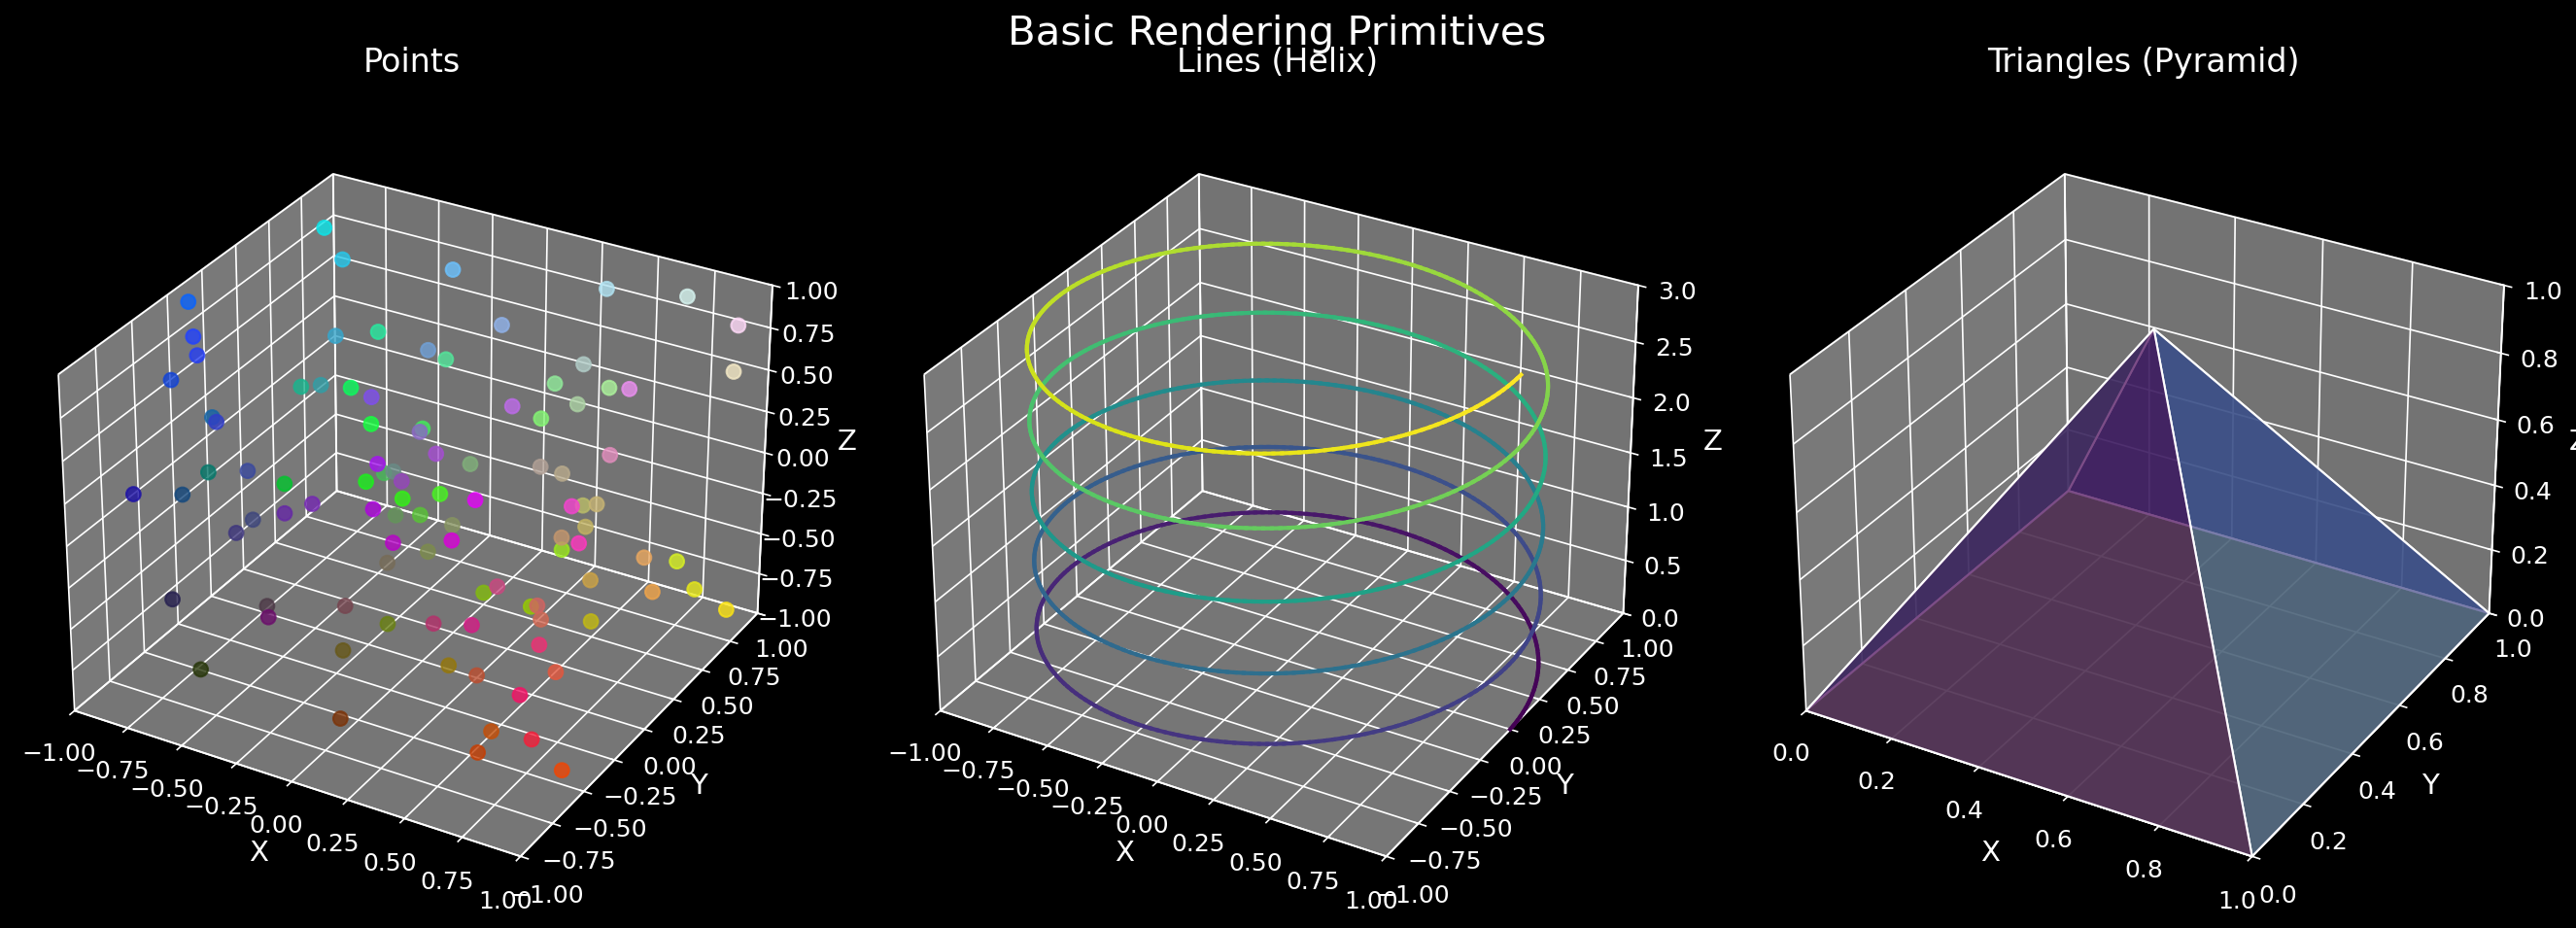

In [27]:
def render_primitives():
    fig = plt.figure(figsize=(18, 6))
    
    # 1. Points
    ax1 = fig.add_subplot(131, projection='3d')
    # Create random points
    n_points = 100
    x = np.random.rand(n_points) * 2 - 1
    y = np.random.rand(n_points) * 2 - 1
    z = np.random.rand(n_points) * 2 - 1
    
    # Plot points with color based on position - normalize colors to 0-1 range
    colors = np.vstack((x, y, z)).T
    colors = (colors + 1) / 2  # Convert from [-1,1] to [0,1] range
    ax1.scatter(x, y, z, c=colors, s=50, alpha=0.8)
    
    ax1.set_title('Points', fontsize=16, color='white', pad=20)
    ax1.set_xlabel('X', color='white')
    ax1.set_ylabel('Y', color='white')
    ax1.set_zlabel('Z', color='white')
    ax1.set_xlim(-1, 1)
    ax1.set_ylim(-1, 1)
    ax1.set_zlim(-1, 1)
    
    # 2. Lines
    ax2 = fig.add_subplot(132, projection='3d')
    
    # Create a helix
    t = np.linspace(0, 10*np.pi, 1000)
    x = np.cos(t)
    y = np.sin(t)
    z = t/10
    
    # Plot the helix with color gradient
    for i in range(len(t)-1):
        ax2.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.viridis(i/len(t)), linewidth=2)
    
    ax2.set_title('Lines (Helix)', fontsize=16, color='white', pad=20)
    ax2.set_xlabel('X', color='white')
    ax2.set_ylabel('Y', color='white')
    ax2.set_zlabel('Z', color='white')
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_zlim(0, 3)
    
    # 3. Triangles (creating a simple mesh)
    ax3 = fig.add_subplot(133, projection='3d')
    
    # Create vertices for a pyramid
    vertices = np.array([
        [0, 0, 0],    # base 1
        [1, 0, 0],    # base 2
        [1, 1, 0],    # base 3
        [0, 1, 0],    # base 4
        [0.5, 0.5, 1]  # top
    ])
    
    # Define the triangular faces using the vertices
    faces = [
        [vertices[0], vertices[1], vertices[4]],  # front face
        [vertices[1], vertices[2], vertices[4]],  # right face
        [vertices[2], vertices[3], vertices[4]],  # back face
        [vertices[3], vertices[0], vertices[4]],  # left face
        [vertices[0], vertices[1], vertices[2], vertices[3]]  # base (a quad, will be triangulated)
    ]
    
    # Create a Poly3DCollection and add it to the axes
    collection = Poly3DCollection(faces, alpha=0.7, linewidths=1, edgecolors='white')
    
    # Set face colors
    face_colors = [plt.cm.viridis(i/len(faces)) for i in range(len(faces))]
    collection.set_facecolor(face_colors)
    
    ax3.add_collection3d(collection)
    
    ax3.set_title('Triangles (Pyramid)', fontsize=16, color='white', pad=20)
    ax3.set_xlabel('X', color='white')
    ax3.set_ylabel('Y', color='white')
    ax3.set_zlabel('Z', color='white')
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.set_zlim(0, 1)
    
    plt.tight_layout()
    plt.suptitle('Basic Rendering Primitives', fontsize=20, y=1.05, color='white')
    plt.show()

# Execute the function
render_primitives()

### Observations for 5.1

The above visualization demonstrates the three fundamental rendering primitives:

1. **Points**: Individual vertices scattered in 3D space, colored based on their position coordinates
2. **Lines**: A continuous helix showing how lines can create complex curved structures
3. **Triangles**: A pyramid mesh composed of triangular faces, demonstrating how triangles form 3D objects

These primitives are successfully displayed on screen and form the foundation for all 3D graphics rendering.

## 3. Geometric Transformations (5.2)

Geometric transformations are essential for positioning, orienting, and scaling objects in 3D space. We implement the fundamental transformation matrices used in computer graphics.

### Transformation Matrix Functions

These functions create 4x4 homogeneous transformation matrices for various operations:

In [22]:
def translation_matrix(tx, ty, tz):
    """Create a 4x4 translation matrix."""
    return np.array([
        [1, 0, 0, tx],
        [0, 1, 0, ty],
        [0, 0, 1, tz],
        [0, 0, 0, 1]
    ])

def rotation_matrix_x(theta):
    """Create a 4x4 rotation matrix around the x-axis."""
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [1, 0, 0, 0],
        [0, c, -s, 0],
        [0, s, c, 0],
        [0, 0, 0, 1]
    ])

def rotation_matrix_y(theta):
    """Create a 4x4 rotation matrix around the y-axis."""
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c, 0, s, 0],
        [0, 1, 0, 0],
        [-s, 0, c, 0],
        [0, 0, 0, 1]
    ])

def rotation_matrix_z(theta):
    """Create a 4x4 rotation matrix around the z-axis."""
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c, -s, 0, 0],
        [s, c, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def scaling_matrix(sx, sy, sz):
    """Create a 4x4 scaling matrix."""
    return np.array([
        [sx, 0, 0, 0],
        [0, sy, 0, 0],
        [0, 0, sz, 0],
        [0, 0, 0, 1]
    ])

### Coordinate System Conversion Functions

Working with homogeneous coordinates allows us to represent all transformations as matrix multiplications:

In [23]:
def to_homogeneous(points):
    """Convert 3D points to homogeneous coordinates."""
    return np.hstack((points, np.ones((points.shape[0], 1))))

def from_homogeneous(points):
    """Convert homogeneous coordinates back to 3D."""
    return points[:, :3] / points[:, 3:4]

def apply_transform(points, matrix):
    """Apply a transformation matrix to a set of 3D points."""
    # Convert to homogeneous coordinates
    homogeneous_points = to_homogeneous(points)
    # Apply transformation
    transformed_points = np.dot(homogeneous_points, matrix.T)
    # Convert back to 3D
    return from_homogeneous(transformed_points)

### Transformation Demonstration

Let's visualize how different transformations affect a 3D cube:

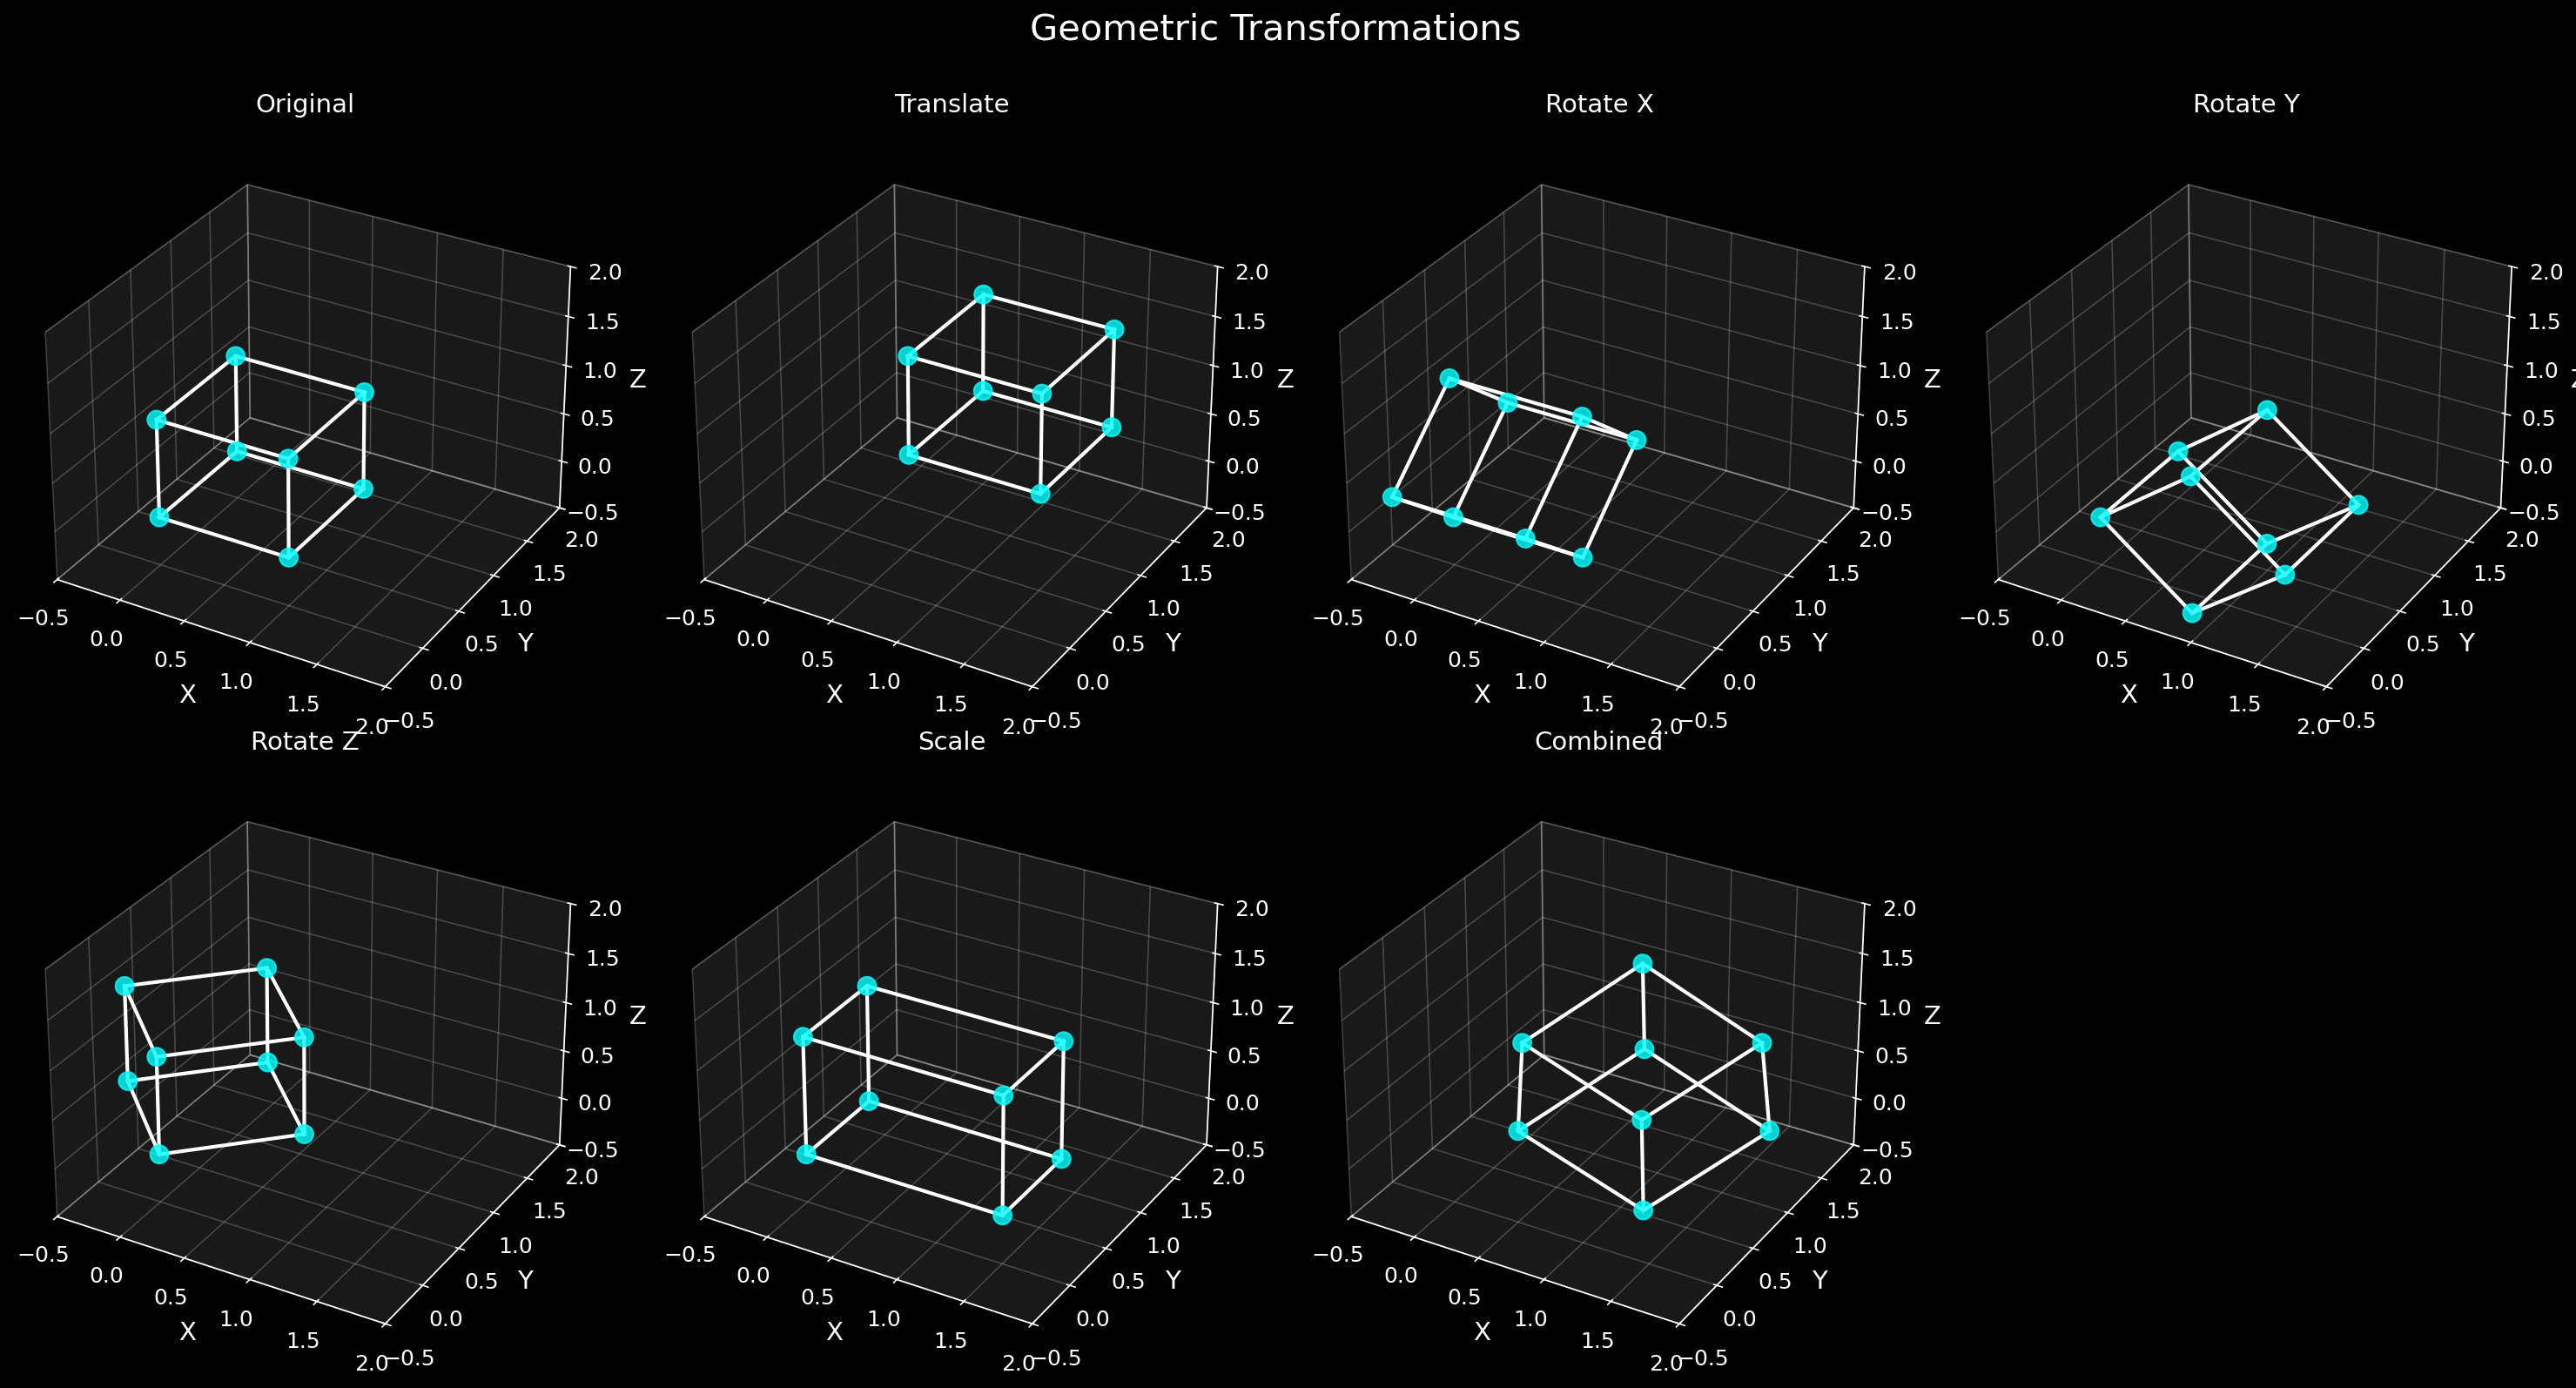

In [24]:
def demonstrate_transformations():
    # Create a cube
    vertices = np.array([
        [0, 0, 0],  # 0: bottom, back, left
        [1, 0, 0],  # 1: bottom, back, right
        [1, 1, 0],  # 2: bottom, front, right
        [0, 1, 0],  # 3: bottom, front, left
        [0, 0, 1],  # 4: top, back, left
        [1, 0, 1],  # 5: top, back, right
        [1, 1, 1],  # 6: top, front, right
        [0, 1, 1]   # 7: top, front, left
    ])
    
    # Define the edges of the cube
    edges = [
        [0, 1], [1, 2], [2, 3], [3, 0],  # bottom face
        [4, 5], [5, 6], [6, 7], [7, 4],  # top face
        [0, 4], [1, 5], [2, 6], [3, 7]   # connecting edges
    ]
    
    # Define transformations
    transformations = [
        ("Original", np.eye(4)),
        ("Translate", translation_matrix(0.5, 0.5, 0.5)),
        ("Rotate X", rotation_matrix_x(np.pi/4)),
        ("Rotate Y", rotation_matrix_y(np.pi/4)),
        ("Rotate Z", rotation_matrix_z(np.pi/4)),
        ("Scale", scaling_matrix(1.5, 0.8, 1.2)),
        ("Combined", np.dot(rotation_matrix_z(np.pi/6), 
                          np.dot(rotation_matrix_y(np.pi/4), 
                               np.dot(translation_matrix(0.3, 0.3, 0.3),
                                    scaling_matrix(1.2, 1.2, 1.2)))))
    ]
    
    # Create figure and axes
    fig = plt.figure(figsize=(20, 10))
    
    # Apply each transformation and plot
    for i, (title, matrix) in enumerate(transformations):
        # Apply transformation
        transformed_vertices = apply_transform(vertices, matrix)
        
        # Create 3D subplot
        ax = fig.add_subplot(2, 4, i+1, projection='3d')
        
        # Plot vertices
        ax.scatter(transformed_vertices[:, 0], 
                  transformed_vertices[:, 1], 
                  transformed_vertices[:, 2], 
                  c='cyan', s=100, alpha=0.8)
        
        # Plot edges
        for edge in edges:
            ax.plot(transformed_vertices[edge, 0], 
                   transformed_vertices[edge, 1], 
                   transformed_vertices[edge, 2], 
                   'white', linewidth=2)
        
        # Set title and labels
        ax.set_title(title, fontsize=14, color='white', pad=15)
        ax.set_xlabel('X', color='white')
        ax.set_ylabel('Y', color='white')
        ax.set_zlabel('Z', color='white')
        
        # Set axis limits with some padding
        ax.set_xlim(-0.5, 2.0)
        ax.set_ylim(-0.5, 2.0)
        ax.set_zlim(-0.5, 2.0)
        
        # Make the panes transparent
        ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
        ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
        ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.1))
        
        # Make the grid lines transparent
        ax.xaxis._axinfo["grid"]['color'] = (1,1,1,0.2)
        ax.yaxis._axinfo["grid"]['color'] = (1,1,1,0.2)
        ax.zaxis._axinfo["grid"]['color'] = (1,1,1,0.2)
    
    plt.tight_layout()
    plt.suptitle('Geometric Transformations', fontsize=20, y=1.05, color='white')
    plt.show()

# Execute the demonstration
demonstrate_transformations()

### Observations for 5.2

The transformation matrices successfully demonstrate:

1. **Translation**: Object moves in 3D space while maintaining shape and orientation
2. **Rotation X/Y/Z**: Object rotates around respective axes, showing different orientations
3. **Scaling**: Object changes size with different scale factors for each axis
4. **Combined**: Multiple transformations applied sequentially create complex movements

All transformations are applied to the rendering primitives and the changes are clearly observable in the visualizations.

## 4. Triangle Rasterization (5.3)

Rasterization is the process of converting geometric primitives into pixels. Here we implement a basic triangle rasterization algorithm using point-in-triangle testing.

### The Rasterization Process

The algorithm works by:
1. Finding the bounding box of the triangle
2. Testing each pixel within the bounding box
3. Determining if the pixel center lies inside the triangle
4. Setting the pixel value if it's inside

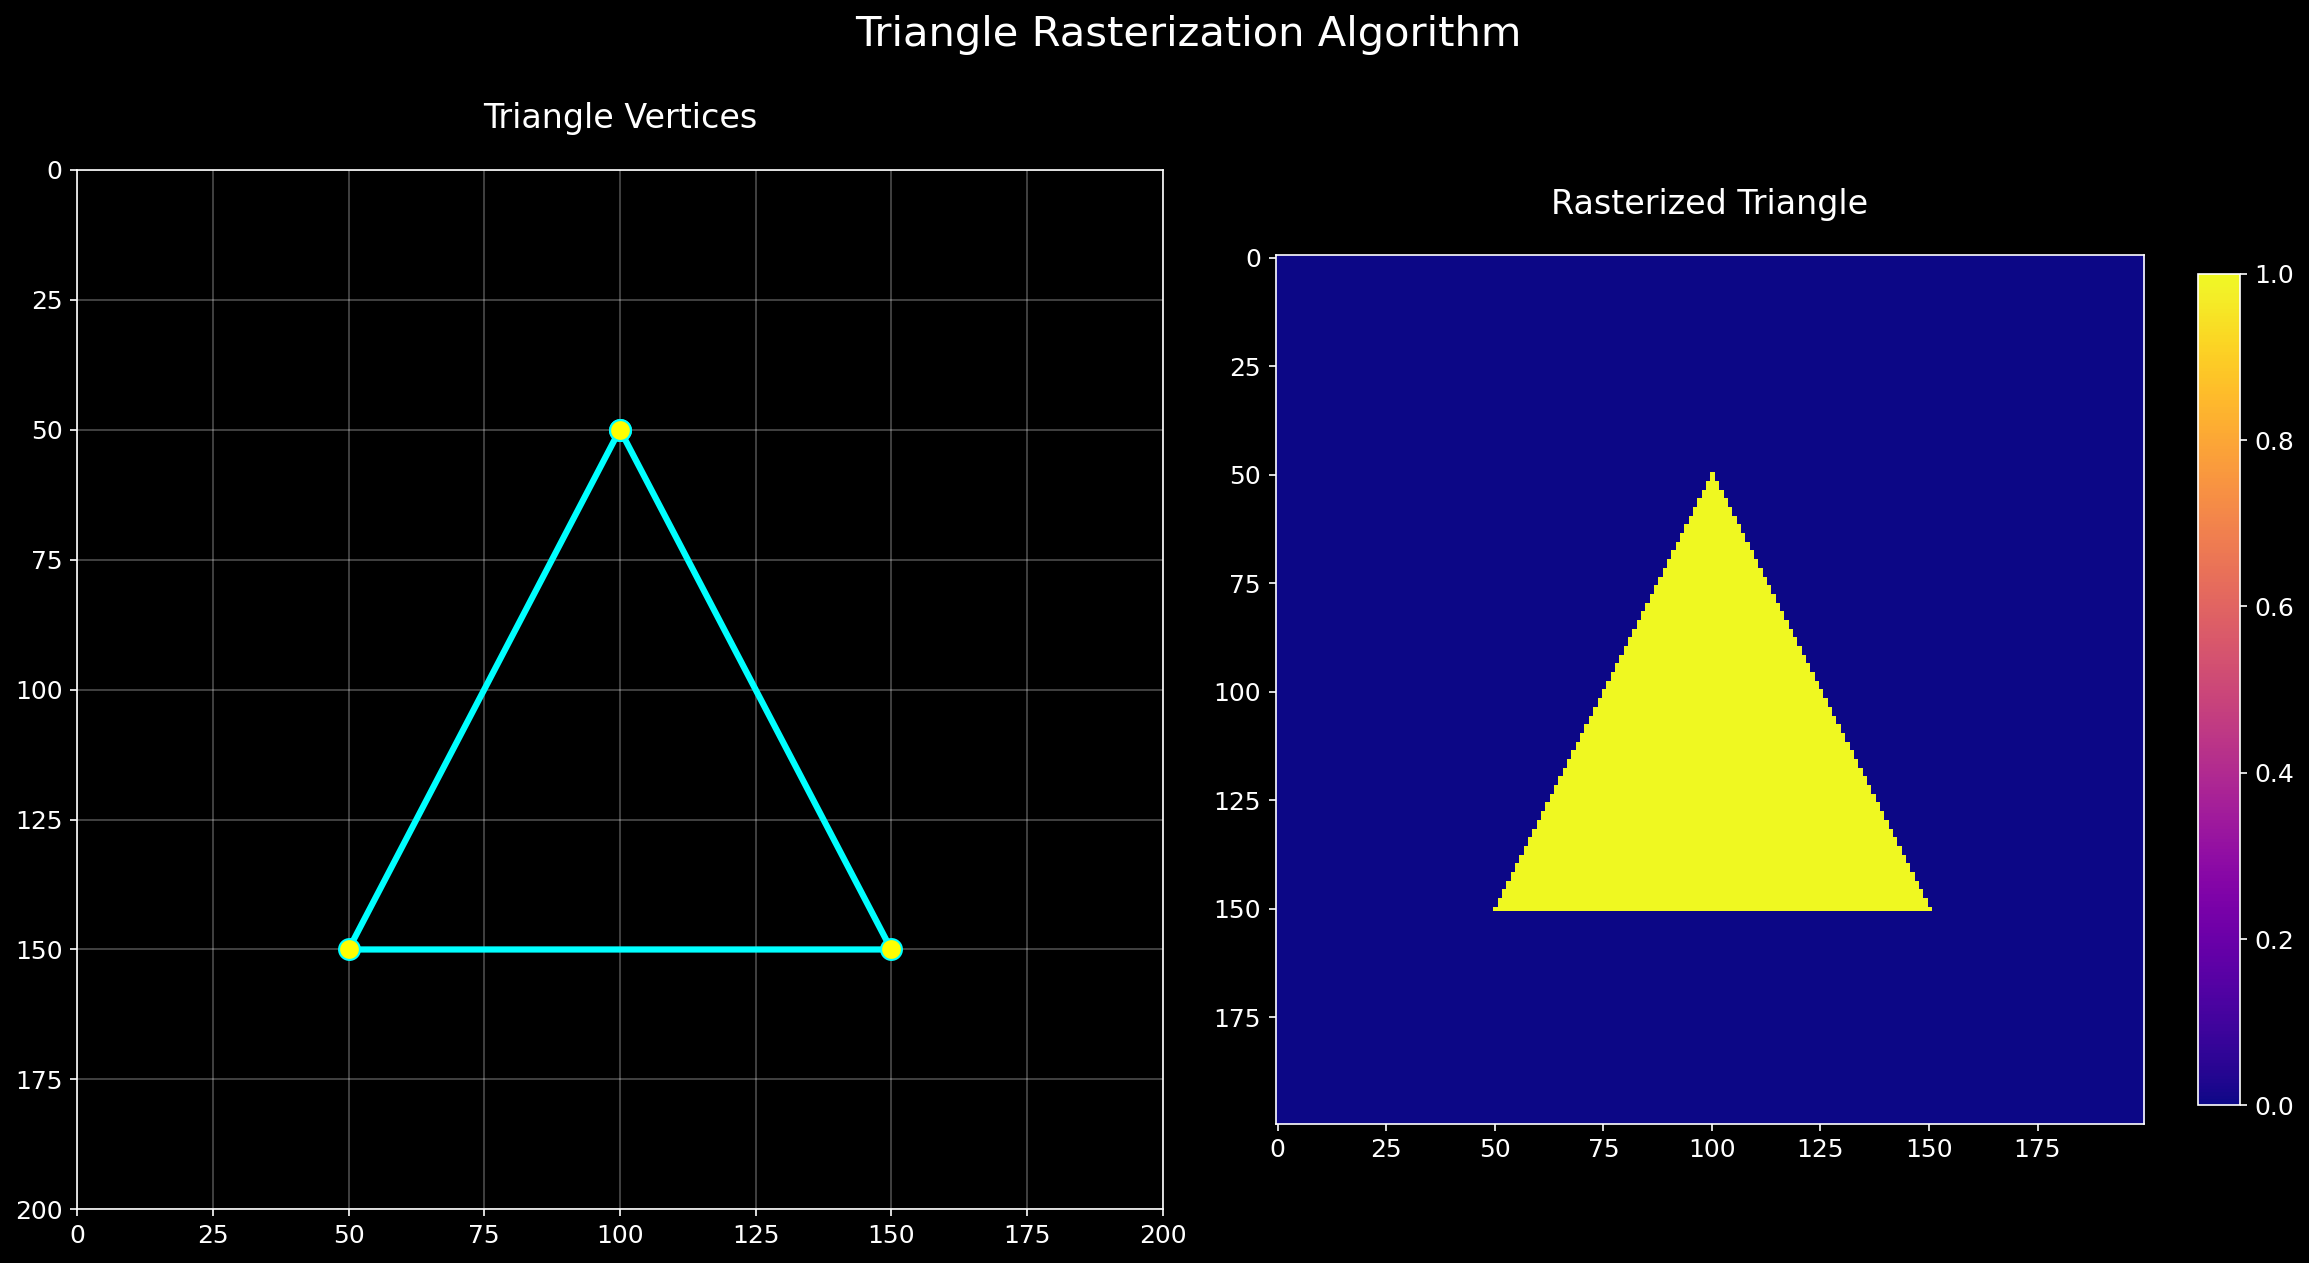

In [25]:
def rasterize_triangle():
    """Demonstrates a simple triangle rasterization algorithm."""
    
    # Define a function to determine if a point is inside a triangle
    def point_in_triangle(point, v1, v2, v3):
        """Check if a point is inside a triangle using barycentric coordinates."""
        def sign(p1, p2, p3):
            return (p1[0] - p3[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p3[1])
        
        d1 = sign(point, v1, v2)
        d2 = sign(point, v2, v3)
        d3 = sign(point, v3, v1)
        
        has_neg = (d1 < 0) or (d2 < 0) or (d3 < 0)
        has_pos = (d1 > 0) or (d2 > 0) or (d3 > 0)
        
        return not (has_neg and has_pos)
    
    # Define the triangle vertices
    triangle_vertices = np.array([
        [100, 50],   # Top vertex
        [50, 150],   # Bottom left
        [150, 150]   # Bottom right
    ])
    
    # Create a canvas to rasterize onto
    canvas_size = 200
    canvas = np.zeros((canvas_size, canvas_size))
    
    # Find bounding box of triangle
    min_x = max(0, int(np.min(triangle_vertices[:, 0])))
    max_x = min(canvas_size - 1, int(np.max(triangle_vertices[:, 0])))
    min_y = max(0, int(np.min(triangle_vertices[:, 1])))
    max_y = min(canvas_size - 1, int(np.max(triangle_vertices[:, 1])))
    
    # Rasterize the triangle
    for y in range(min_y, max_y + 1):
        for x in range(min_x, max_x + 1):
            point = np.array([x, y])
            if point_in_triangle(point, triangle_vertices[0], triangle_vertices[1], triangle_vertices[2]):
                canvas[y, x] = 1
    
    # Visualize the rasterization process
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot the triangle outline
    triangle_plot = triangle_vertices[[0, 1, 2, 0], :]
    ax1.plot(triangle_plot[:, 0], triangle_plot[:, 1], 'o-', 
             color='cyan', markersize=10, linewidth=3, markerfacecolor='yellow')
    ax1.set_title('Triangle Vertices', fontsize=16, color='white', pad=20)
    ax1.set_xlim(0, canvas_size)
    ax1.set_ylim(canvas_size, 0)  # Invert y-axis to match image coordinates
    ax1.grid(True, alpha=0.3)
    ax1.set_facecolor('black')
    
    # Plot the rasterized triangle
    im = ax2.imshow(canvas, cmap='plasma', interpolation='nearest')
    ax2.set_title('Rasterized Triangle', fontsize=16, color='white', pad=20)
    plt.colorbar(im, ax=ax2, shrink=0.8)
    
    plt.tight_layout()
    plt.suptitle('Triangle Rasterization Algorithm', fontsize=20, y=1.05, color='white')
    plt.show()
    
    return canvas

# Execute the rasterization demonstration
triangle_canvas = rasterize_triangle()

### Observations for 5.3

The simple rasterization algorithm successfully converts the geometric triangle into pixels:

1. **Bounding Box Optimization**: Only pixels within the triangle's bounding rectangle are tested
2. **Point-in-Triangle Test**: Uses barycentric coordinates to determine pixel inclusion
3. **Pixel Coverage**: Each pixel center that falls inside the triangle is filled
4. **Visual Result**: The rasterized triangle maintains the original shape while being discretized into a pixel grid

This demonstrates the fundamental process of converting vector graphics into raster images for display.

## 5. Lighting and Shading (5.4)

Shading techniques determine how surfaces appear under different lighting conditions. We'll compare flat shading and Gouraud shading techniques.

### Shading Techniques Explained

- **Flat Shading**: Each polygon face has a uniform color based on its orientation to the light source
- **Gouraud Shading**: Colors are calculated at vertices and interpolated across the surface
- **Surface Normals**: Vectors perpendicular to the surface, essential for lighting calculations

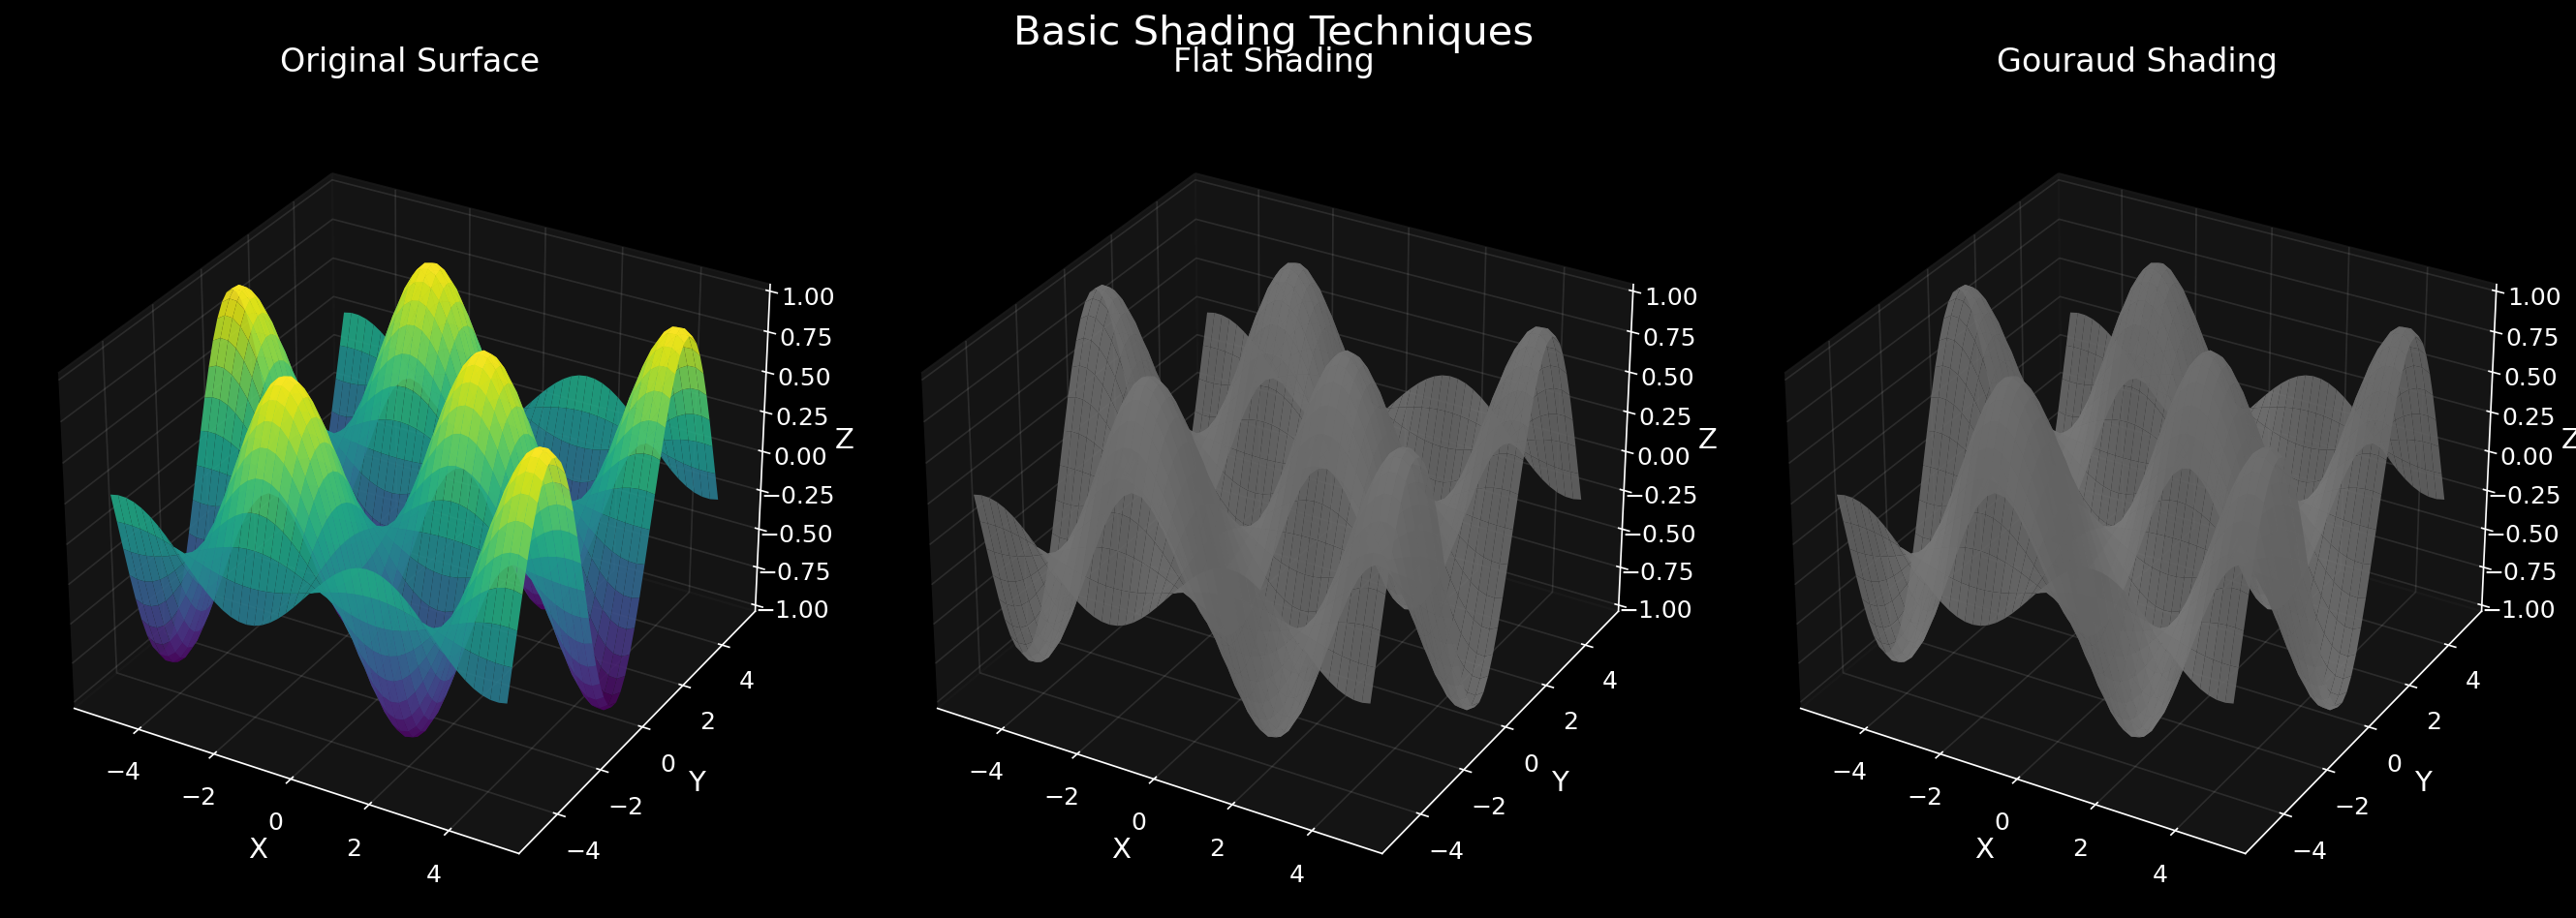

In [26]:
def demonstrate_shading():
    """Demonstrates flat shading and Gouraud shading techniques."""
    
    # Create a simple surface (a plane with a sine wave)
    n = 50
    x = np.linspace(-5, 5, n)
    y = np.linspace(-5, 5, n)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(X) * np.cos(Y)
    
    # Compute the surface normals
    dx = np.gradient(Z, axis=1)
    dy = np.gradient(Z, axis=0)
    
    # Stack the gradients with ones to get normal vectors
    normals = np.stack([-dx, -dy, np.ones_like(Z)], axis=-1)
    
    # Normalize the normals
    norm = np.sqrt(np.sum(normals**2, axis=2))
    normals = normals / norm[:, :, np.newaxis]
    
    # Define a light source
    light_dir = np.array([1, 1, 1])
    light_dir = light_dir / np.sqrt(np.sum(light_dir**2))
    
    # Compute the illumination for flat shading (constant per face)
    flat_illumination = np.zeros_like(Z)
    for i in range(n-1):
        for j in range(n-1):
            # Use the average normal for the face (a quad from 4 points)
            face_normal = (normals[i, j] + normals[i+1, j] + 
                          normals[i, j+1] + normals[i+1, j+1]) / 4
            face_normal = face_normal / np.sqrt(np.sum(face_normal**2))
            
            # Compute the illumination using the dot product
            illum = np.dot(face_normal, light_dir)
            illum = max(0.1, illum)  # Ambient light term
            
            # Set the illumination for this face
            flat_illumination[i:i+2, j:j+2] = illum
    
    # Compute the illumination for Gouraud shading (per vertex)
    gouraud_illumination = np.zeros_like(Z)
    for i in range(n):
        for j in range(n):
            # Use the vertex normal directly
            vertex_normal = normals[i, j]
            
            # Compute the illumination using the dot product
            illum = np.dot(vertex_normal, light_dir)
            illum = max(0.1, illum)  # Ambient light term
            
            # Set the illumination for this vertex
            gouraud_illumination[i, j] = illum
    
    # Visualize the shading techniques
    fig = plt.figure(figsize=(18, 6))
    
    # Original surface
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none', alpha=0.9)
    ax1.set_title('Original Surface', fontsize=16, color='white', pad=20)
    ax1.set_xlabel('X', color='white')
    ax1.set_ylabel('Y', color='white')
    ax1.set_zlabel('Z', color='white')
    
    # Flat shading
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(X, Y, Z, facecolors=plt.cm.gray(flat_illumination), 
                           edgecolor='none', alpha=0.9)
    ax2.set_title('Flat Shading', fontsize=16, color='white', pad=20)
    ax2.set_xlabel('X', color='white')
    ax2.set_ylabel('Y', color='white')
    ax2.set_zlabel('Z', color='white')
    
    # Gouraud shading
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(X, Y, Z, facecolors=plt.cm.gray(gouraud_illumination), 
                           edgecolor='none', alpha=0.9)
    ax3.set_title('Gouraud Shading', fontsize=16, color='white', pad=20)
    ax3.set_xlabel('X', color='white')
    ax3.set_ylabel('Y', color='white')
    ax3.set_zlabel('Z', color='white')
    
    # Enhance the appearance of all subplots
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_pane_color((0.1, 0.1, 0.1, 0.8))
        ax.yaxis.set_pane_color((0.1, 0.1, 0.1, 0.8))
        ax.zaxis.set_pane_color((0.1, 0.1, 0.1, 0.8))
        ax.xaxis._axinfo["grid"]['color'] = (1,1,1,0.1)
        ax.yaxis._axinfo["grid"]['color'] = (1,1,1,0.1)
        ax.zaxis._axinfo["grid"]['color'] = (1,1,1,0.1)
    
    plt.tight_layout()
    plt.suptitle('Basic Shading Techniques', fontsize=20, y=1.05, color='white')
    plt.show()

# Execute the shading demonstration
demonstrate_shading()

### Observations for 5.4

The shading techniques demonstrate clear differences in surface appearance:

1. **Original Surface**: Shows the geometric form without lighting considerations
2. **Flat Shading**: Creates faceted appearance with uniform color per face, giving a more angular look
3. **Gouraud Shading**: Provides smooth color transitions across the surface by interpolating vertex colors




### Summary of Achievements

**5.1 Basic Rendering Primitives**: Successfully implemented and displayed points, lines, and triangles on screen with clear visual distinction and proper 3D representation.

**5.2 Transformation Matrices**: Created and applied translation, rotation, and scaling transformations to rendering primitives, with clear observation of the changes in object position, orientation, and size.

**5.3 Triangle Rasterization**: Implemented a functional rasterization algorithm that converts geometric triangles into pixel representations, demonstrating the fundamental process of vector-to-raster conversion.

**5.4 Shading Techniques**: Successfully implemented both flat shading and Gouraud shading techniques, showing clear differences in surface appearance and lighting simulation.

